In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statistics import variance
import seaborn as sns
import networkx as nx

In [ ]:
df = pd.read_csv("2015-18_(300, 1008).csv")
df = df.transpose()
df.drop(df.index[[0, 1]], inplace = True)

# Calculating Log Returns:

In [ ]:
count=0
returns = pd.DataFrame(np.zeros((1006, 300)))
for i in range(0, 300):
    for j in range (1, 1006):
        if df[i][j]==np.NaN or df[i][j-1]==np.NaN or df[i][j]<=0 or df[i][j-1]<=0:
         count=count+1
         continue
        returns[i][j] = np.log(df[i][j]) - np.log(df[i][j-1])

print(count)

14


# Price Prediction by Black Scholes Model:

In [ ]:
bs_df = pd.DataFrame(np.zeros((1006, 300)))
for i in range(0, 300):
    # drift coefficent
    mu = np.mean(returns[i][:])
    # number of steps
    n = 1005
    # time in years
    T = 4
    # number of simulations for different values of B(t)
    M = 1
    # initial stock price
    S0 = df[i][0]
    # volatility
    sigma = np.sqrt(np.var(returns[i][:]))
    # calc each time step
    dt = T/n

    # simulation using numpy arrays
    St = np.exp(
        (mu - sigma ** 2 / 2) * dt
        + sigma * np.random.normal(0, np.sqrt(dt), size=(M,n)).T
    )

    # include array of 1's
    St = np.vstack([np.ones(M), St])

    # multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
    St = S0 * St.cumprod(axis=0)
    bs_df[i][:] = St.reshape(1006,)


In [ ]:
bs_returns = pd.DataFrame(np.zeros((1006, 300)))
for i in range(0, 300):
    for j in range (1, 1006):
        if bs_df[i][j]==np.NaN or bs_df[i][j-1]==np.NaN or bs_df[i][j]<=0 or bs_df[i][j-1]<=0:
         continue
        bs_returns[i][j] = np.log(bs_df[i][j]) - np.log(bs_df[i][j-1])

In [ ]:
bs_df.to_csv('BlackScholes Prices.csv')
bs_returns.to_csv('Returns from BS Prices.csv')
returns.to_csv('Returns.csv')

# Correlation Matrix:

In [ ]:
BS_CorrelationMatrix = bs_returns.corr()
CorrelationMatrix = returns.corr()

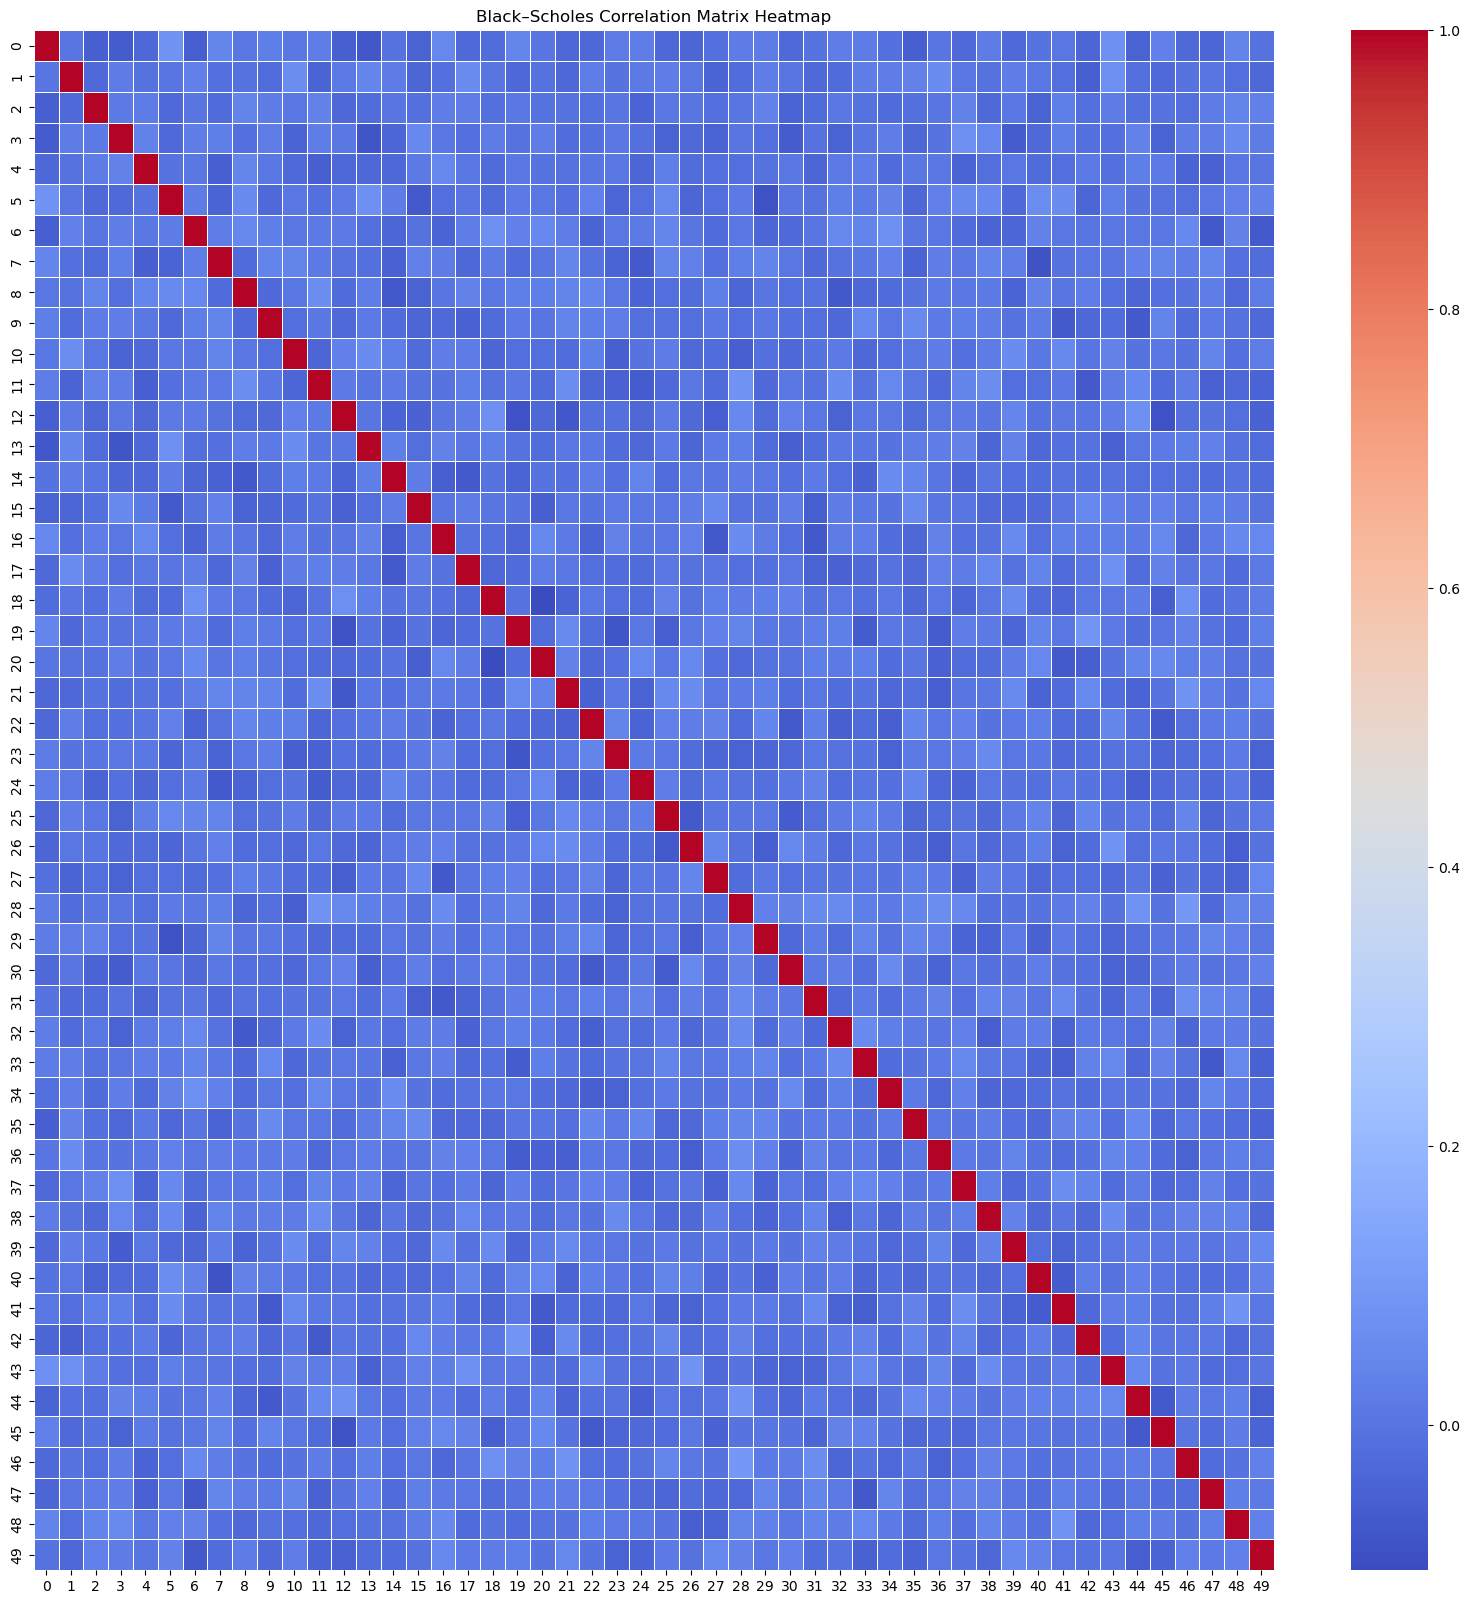

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(BS_CorrelationMatrix.iloc[:50, :50], annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Black–Scholes Correlation Matrix Heatmap')
plt.show()

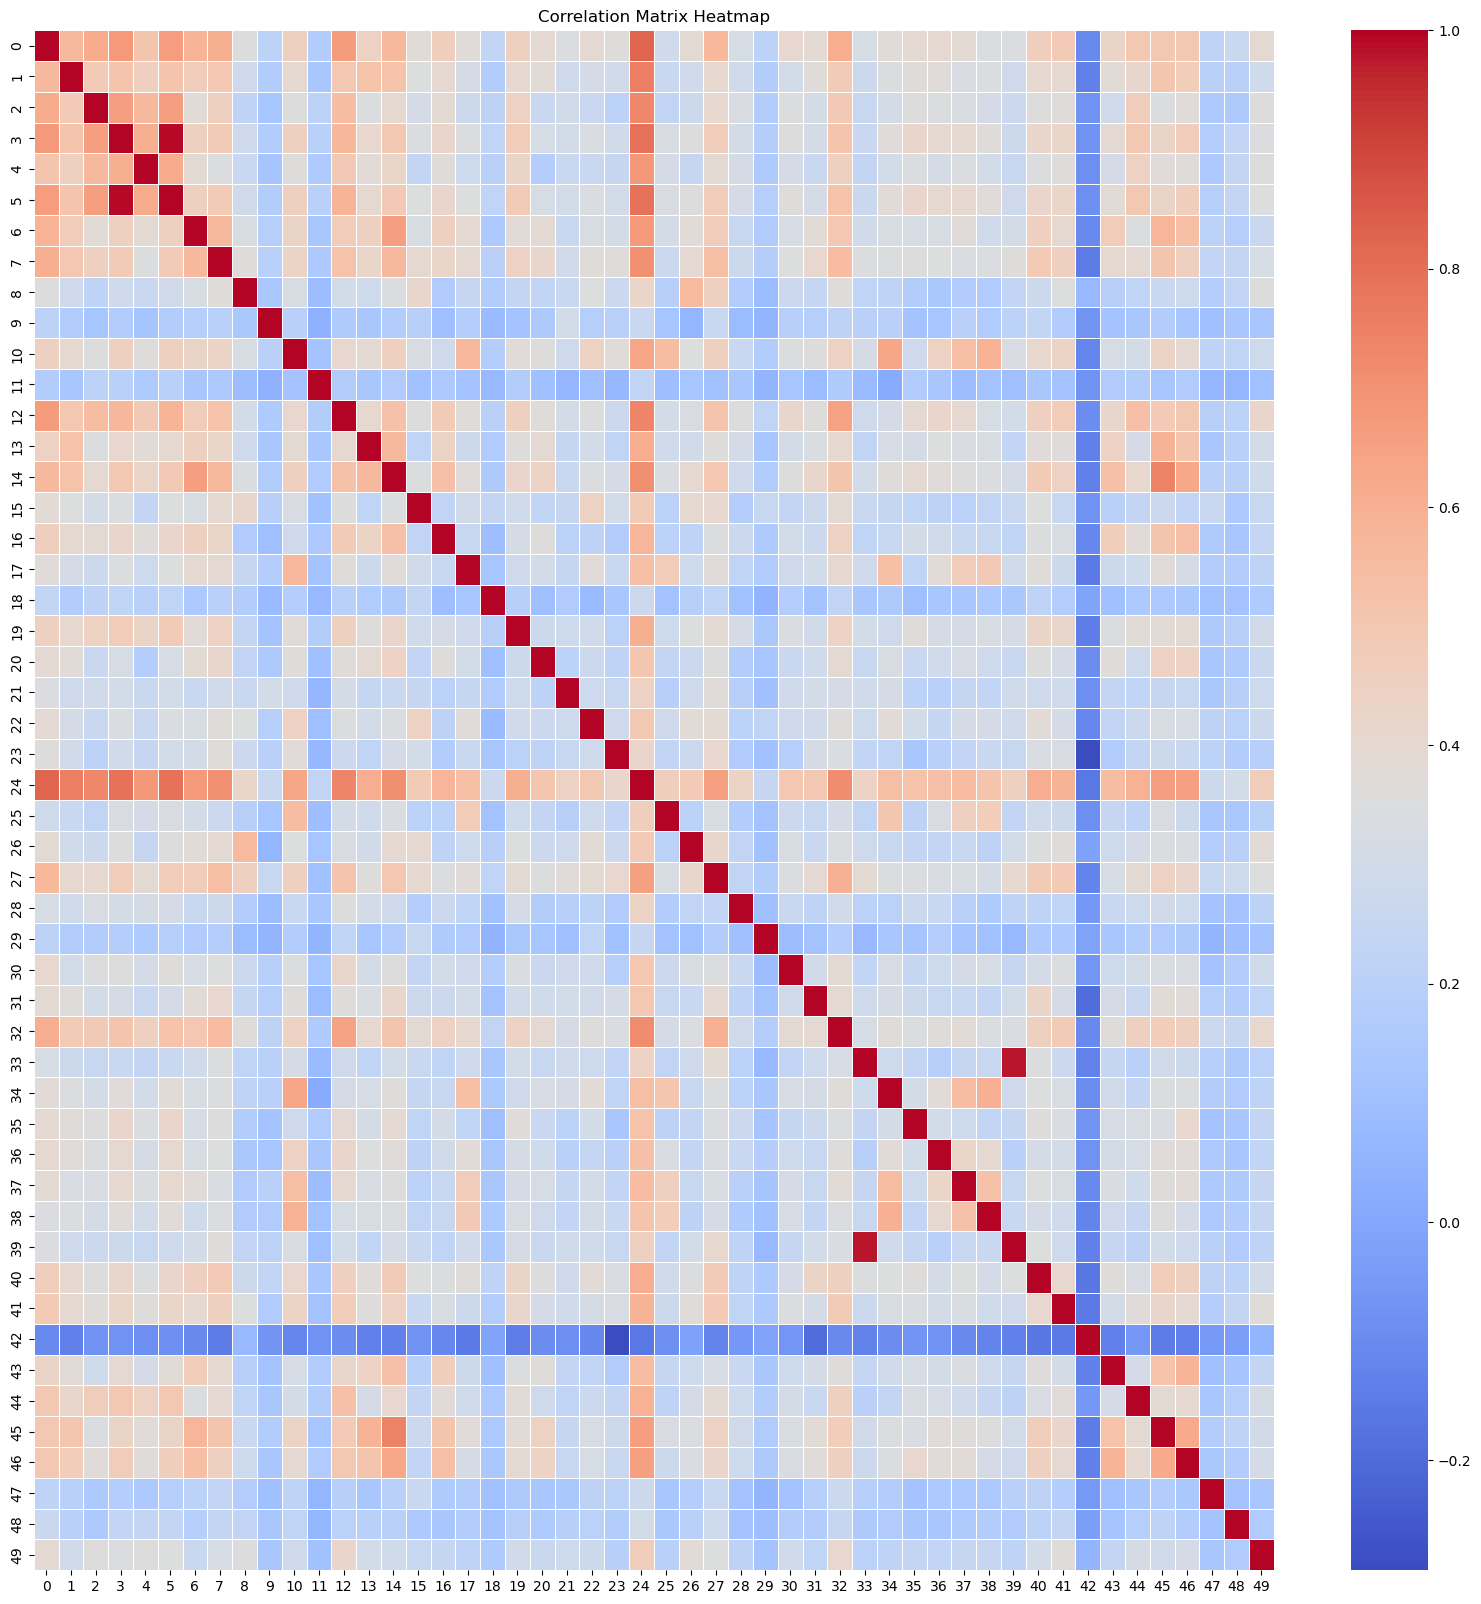

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(CorrelationMatrix.iloc[:50, :50], annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
BS_CorrelationMatrix.to_csv('BS CorrelationMatrix.csv')
CorrelationMatrix.to_csv('CorrelationMatrix.csv')

In [ ]:
correl_matrix = pd.read_csv('CorrelationMatrix.csv')
correl_matrix.drop('Unnamed: 0', axis = 1, inplace = True)
bscorrel_matrix = pd.read_csv('BS CorrelationMatrix.csv')
bscorrel_matrix.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
distances = pd.DataFrame(np.zeros((300, 300)))
values = []
for i in range(0, 300):
    for j in range (0, 300):
        distances.iat[i, j] = np.sqrt(2*(1 - correl_matrix.iat[i, j]))
        if(distances.iat[i, j]):
            values.append(distances.iat[i, j])
values.sort()

bsdistances = pd.DataFrame(np.zeros((300, 300)))
bsvalues = []
for i in range(0, 300):
    for j in range (0, 300):
        bsdistances.iat[i, j] = np.sqrt(2*(1 - bscorrel_matrix.iat[i, j]))
        if(bsdistances.iat[i, j]):
            bsvalues.append(bsdistances.iat[i, j])
bsvalues.sort()

# Graph Growth (Financial Market):

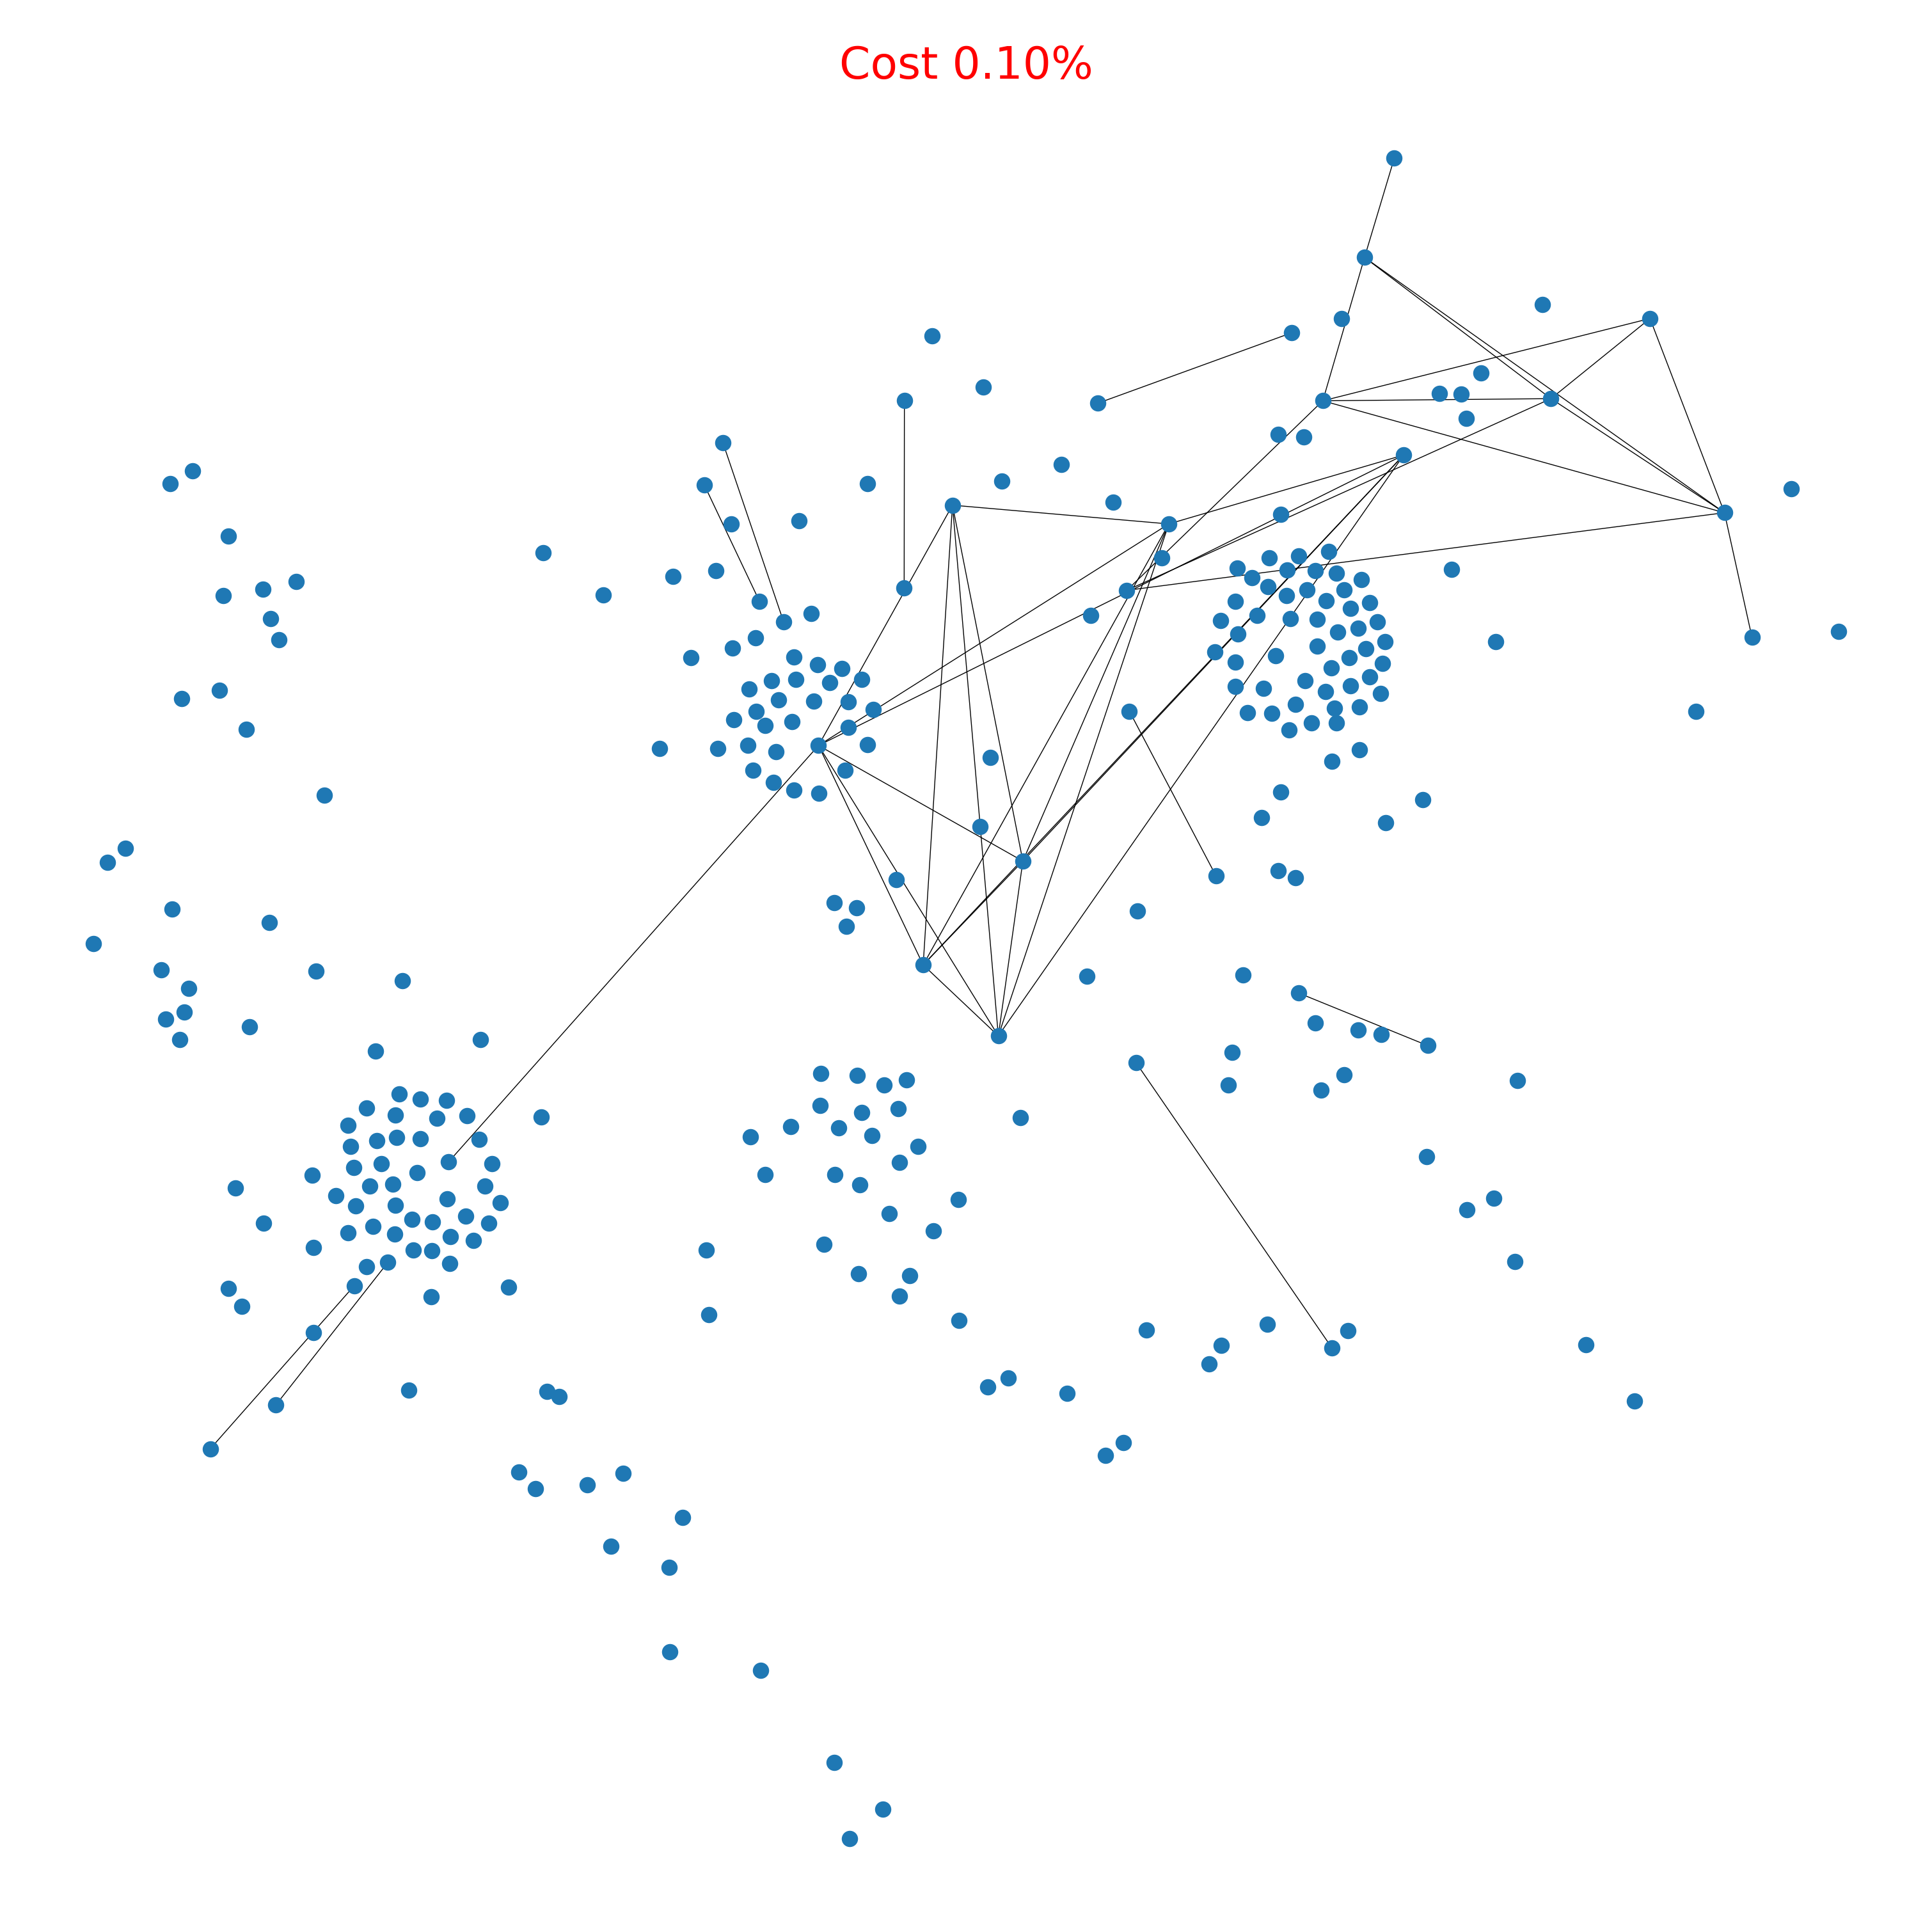

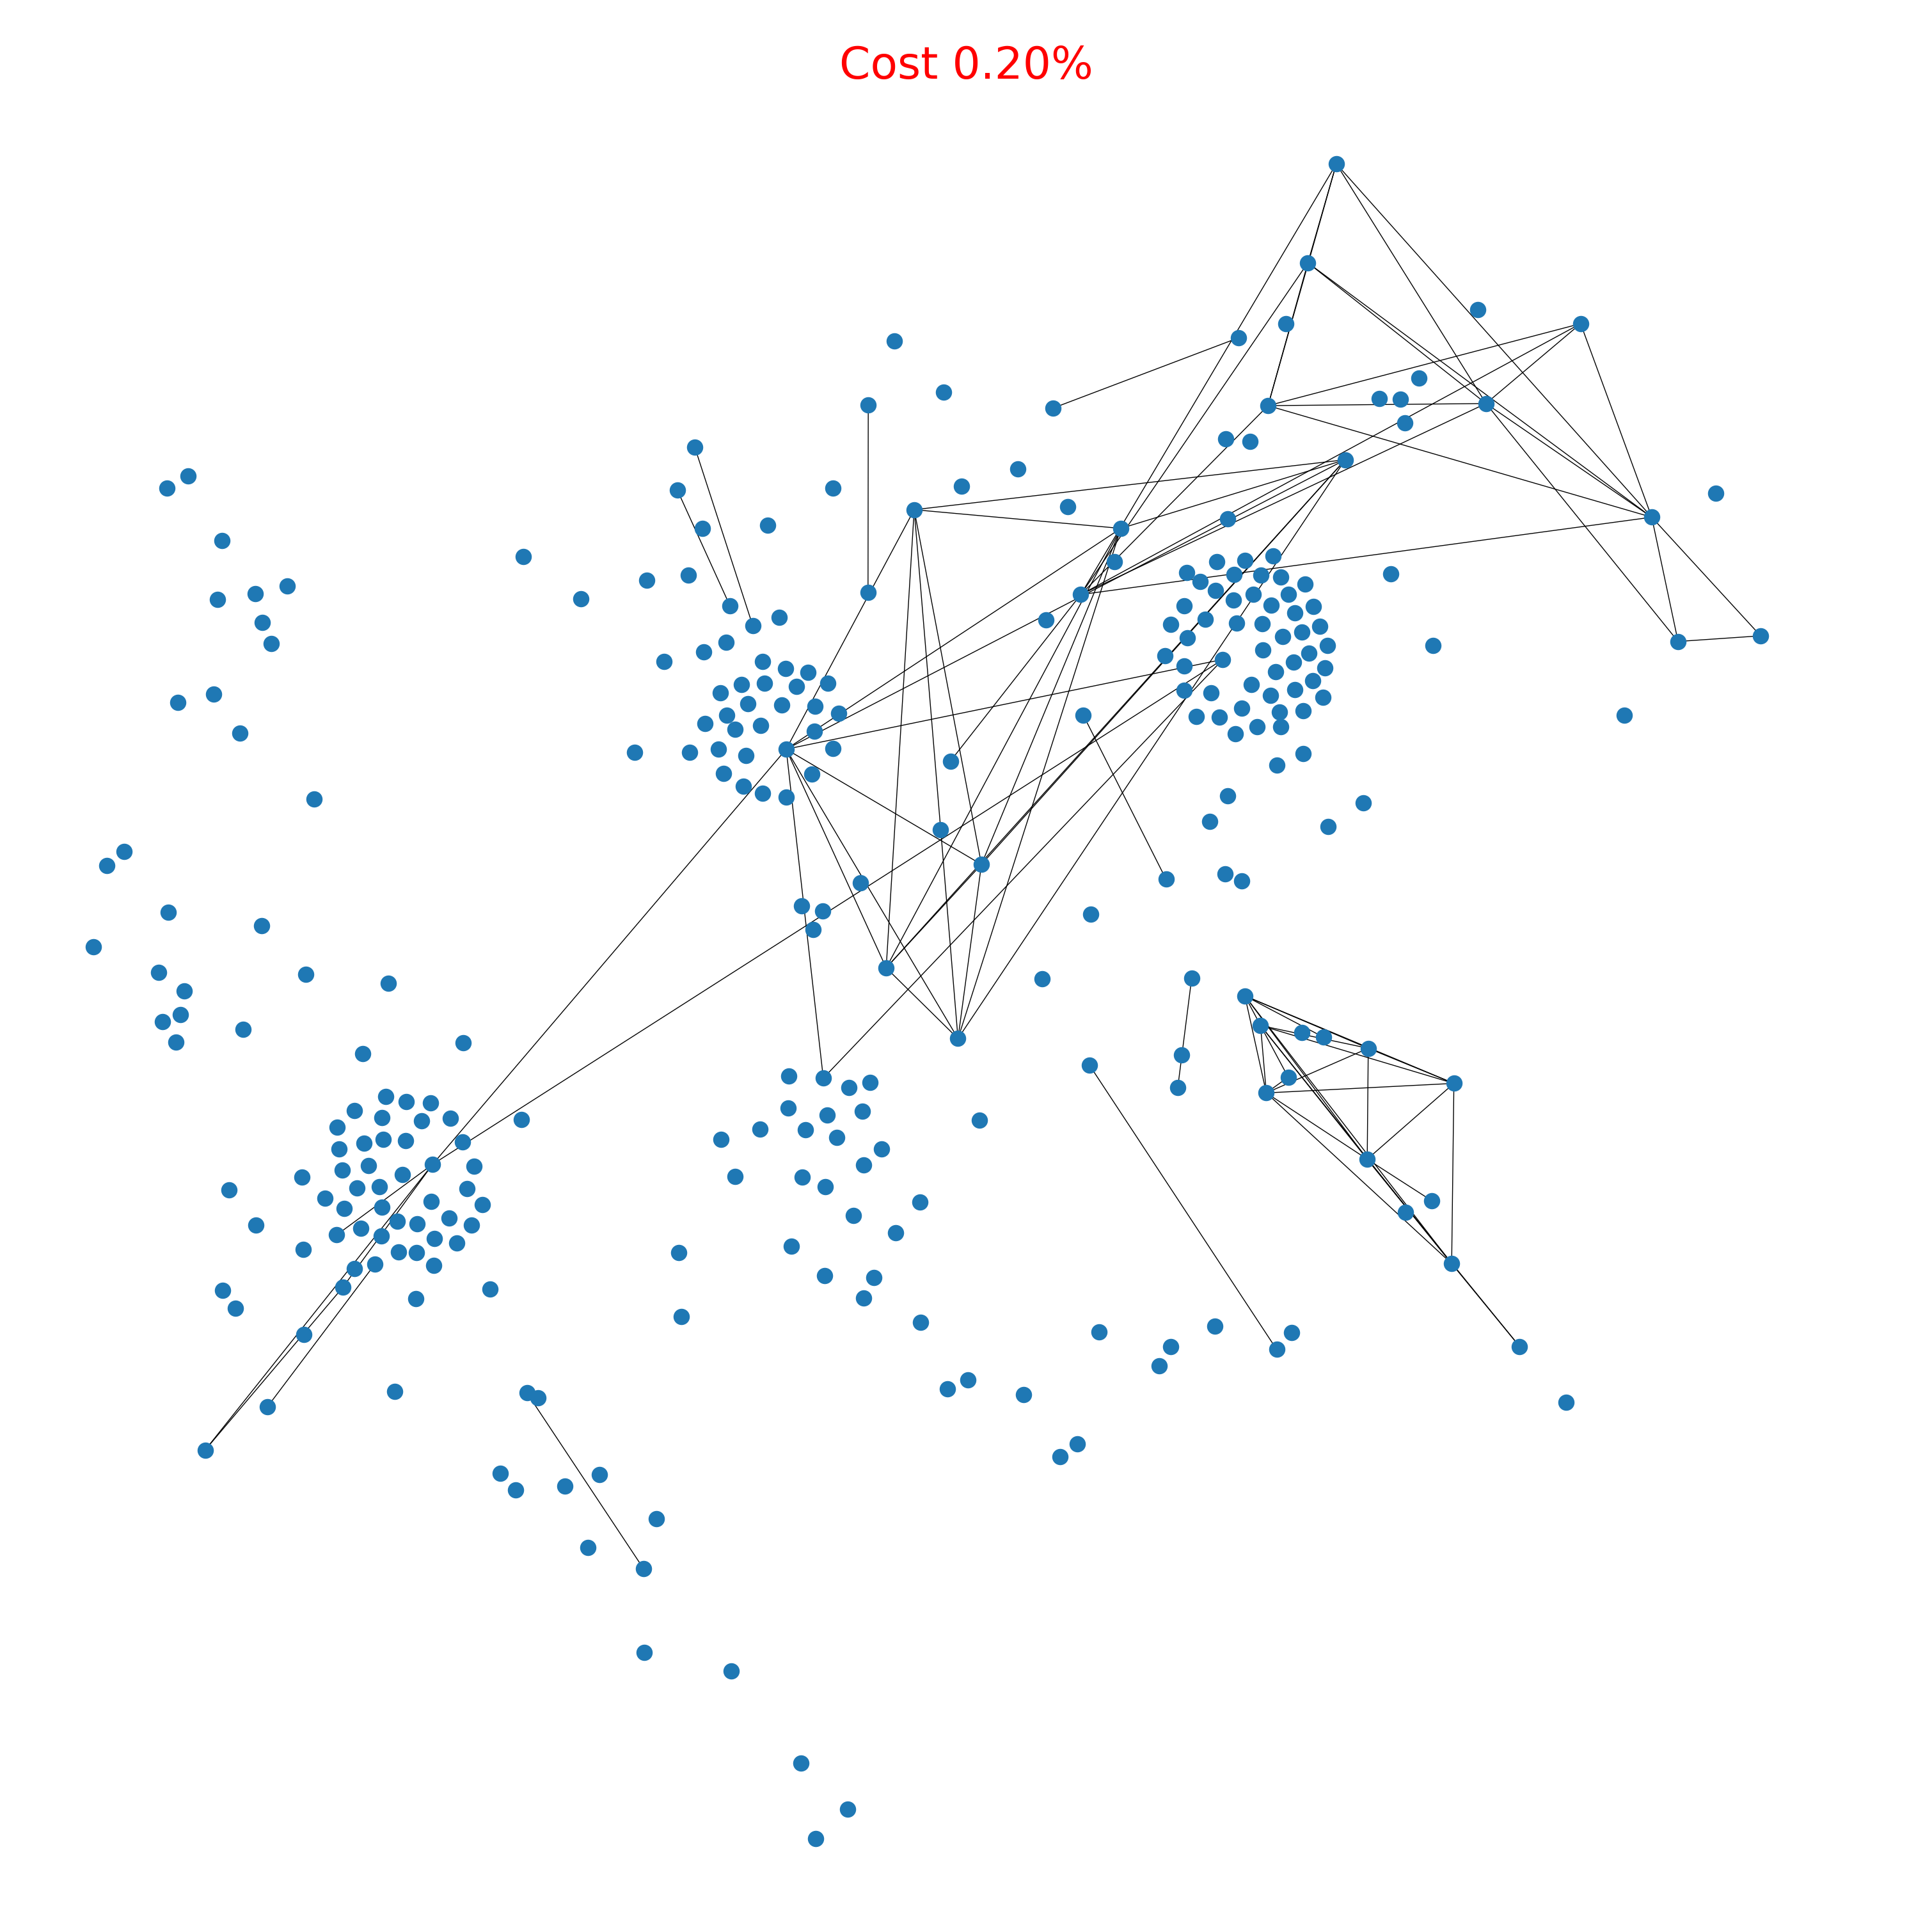

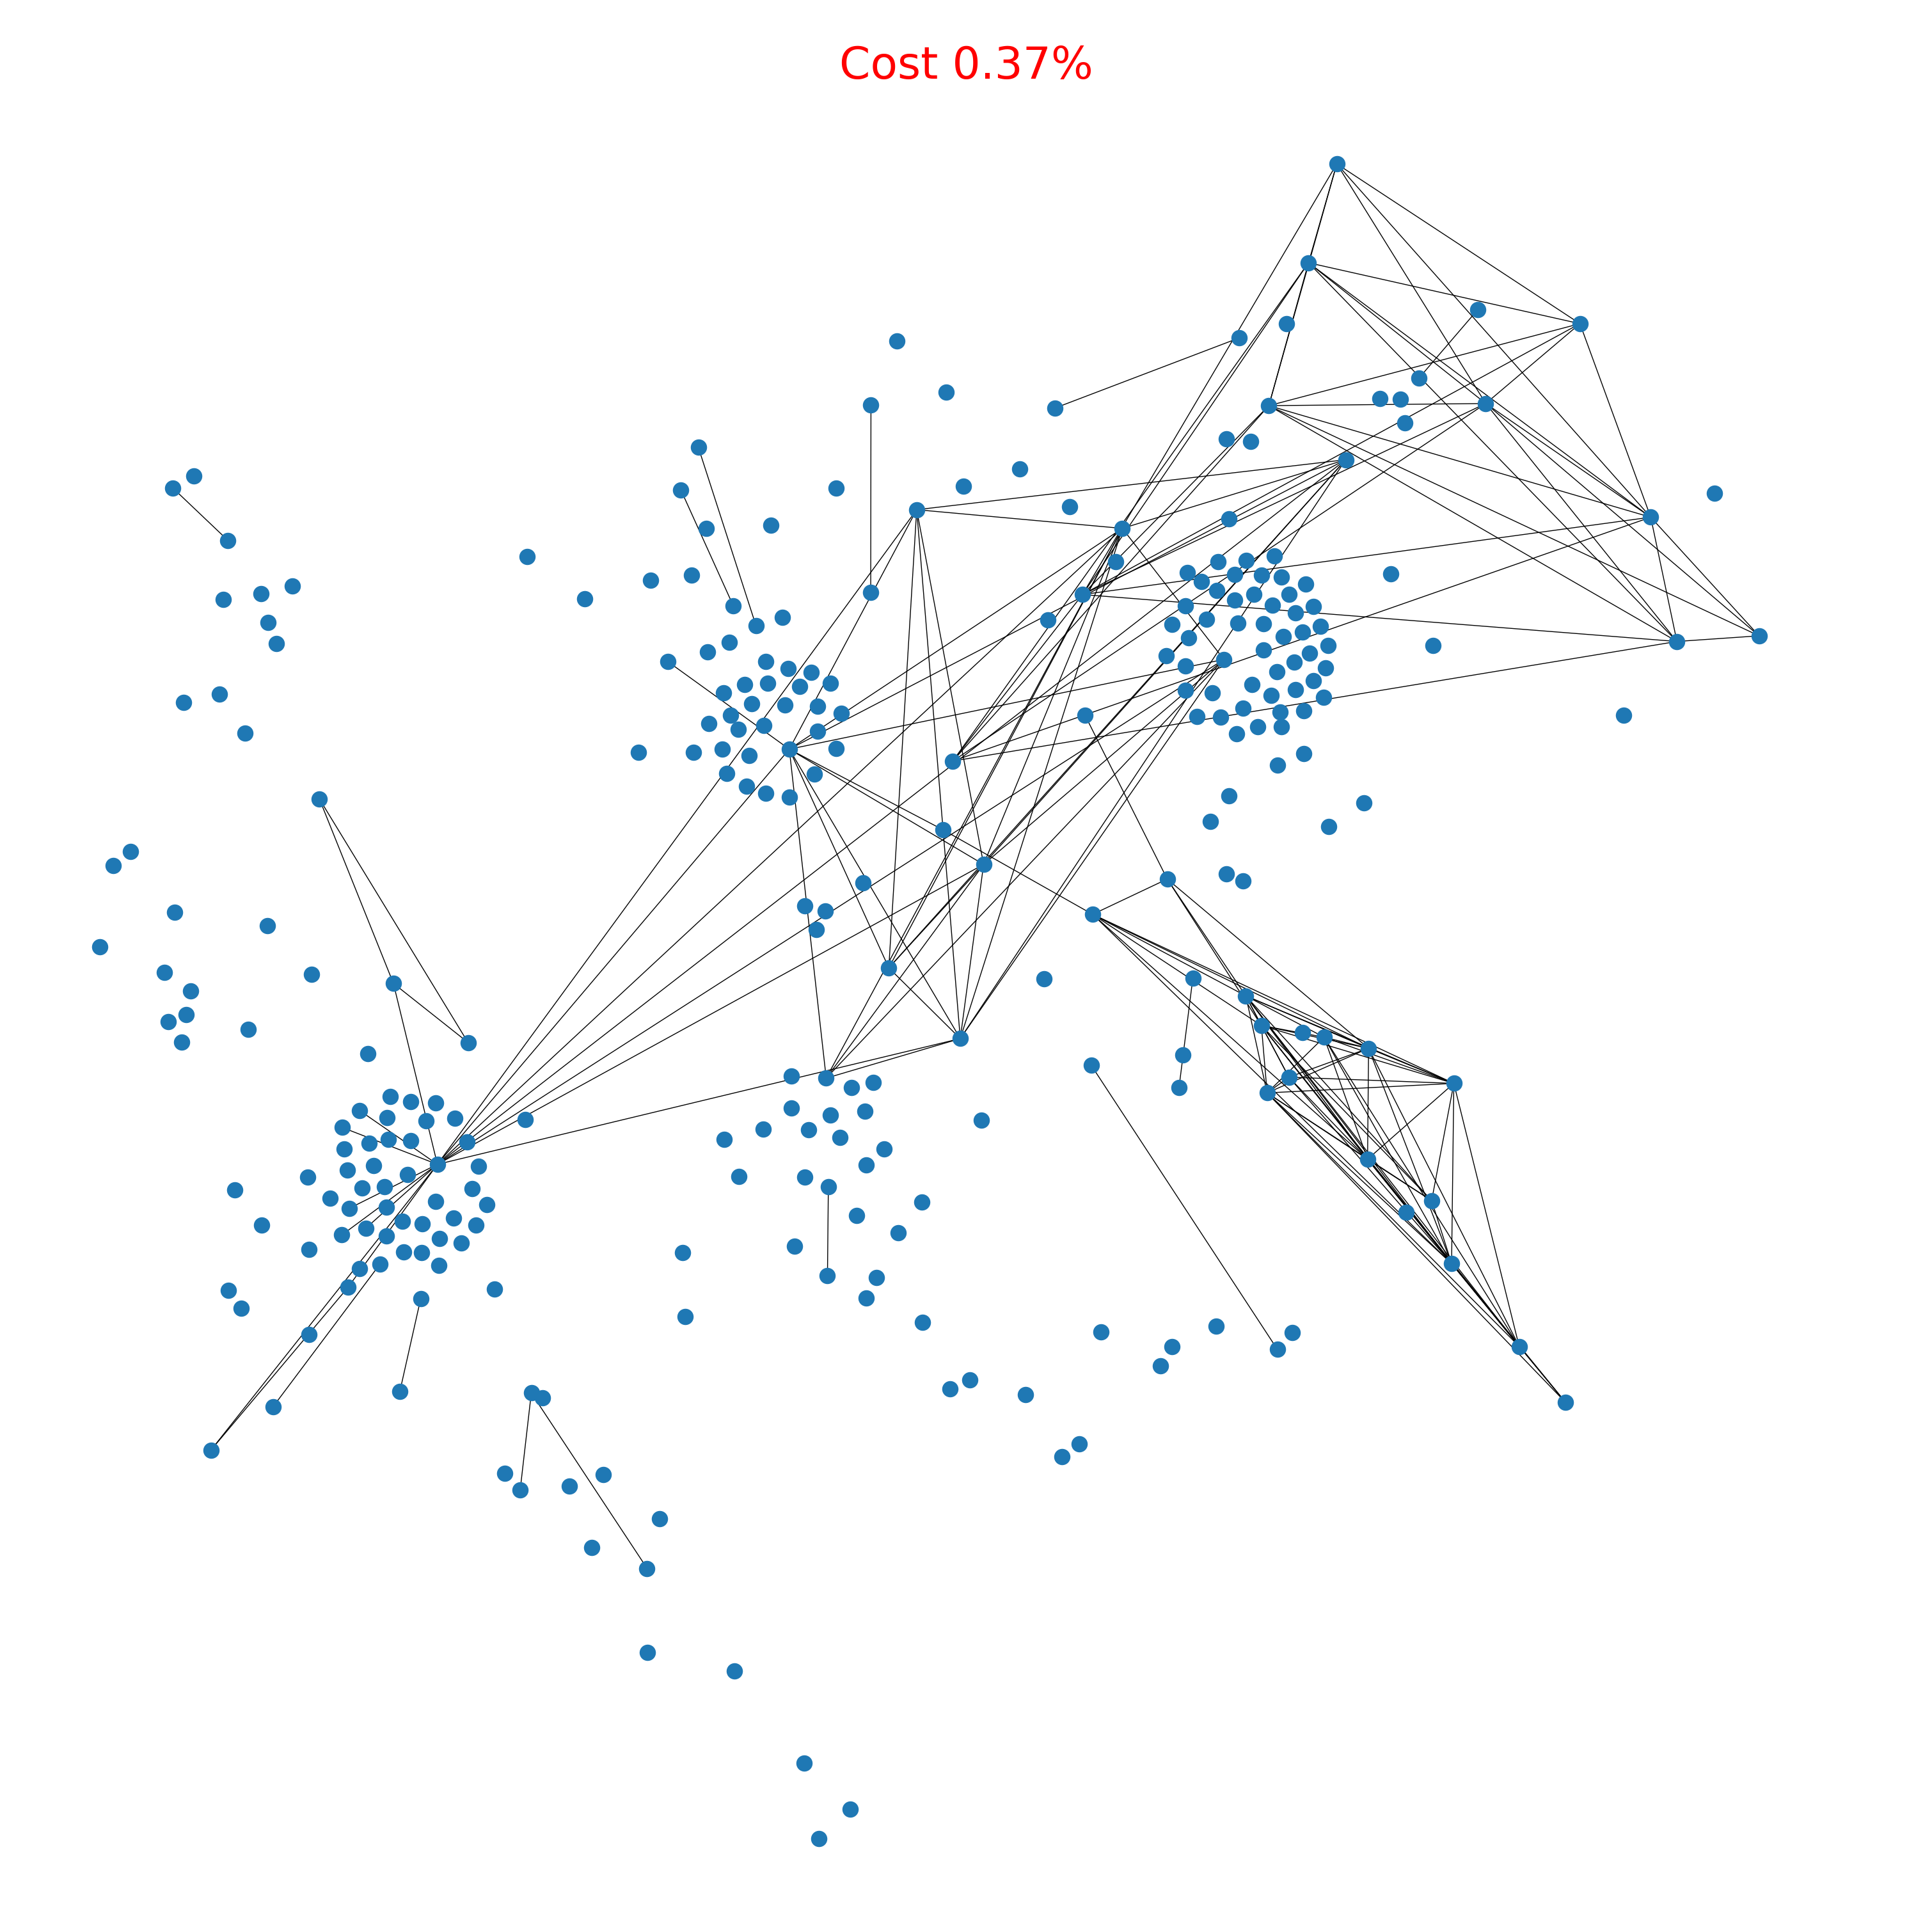

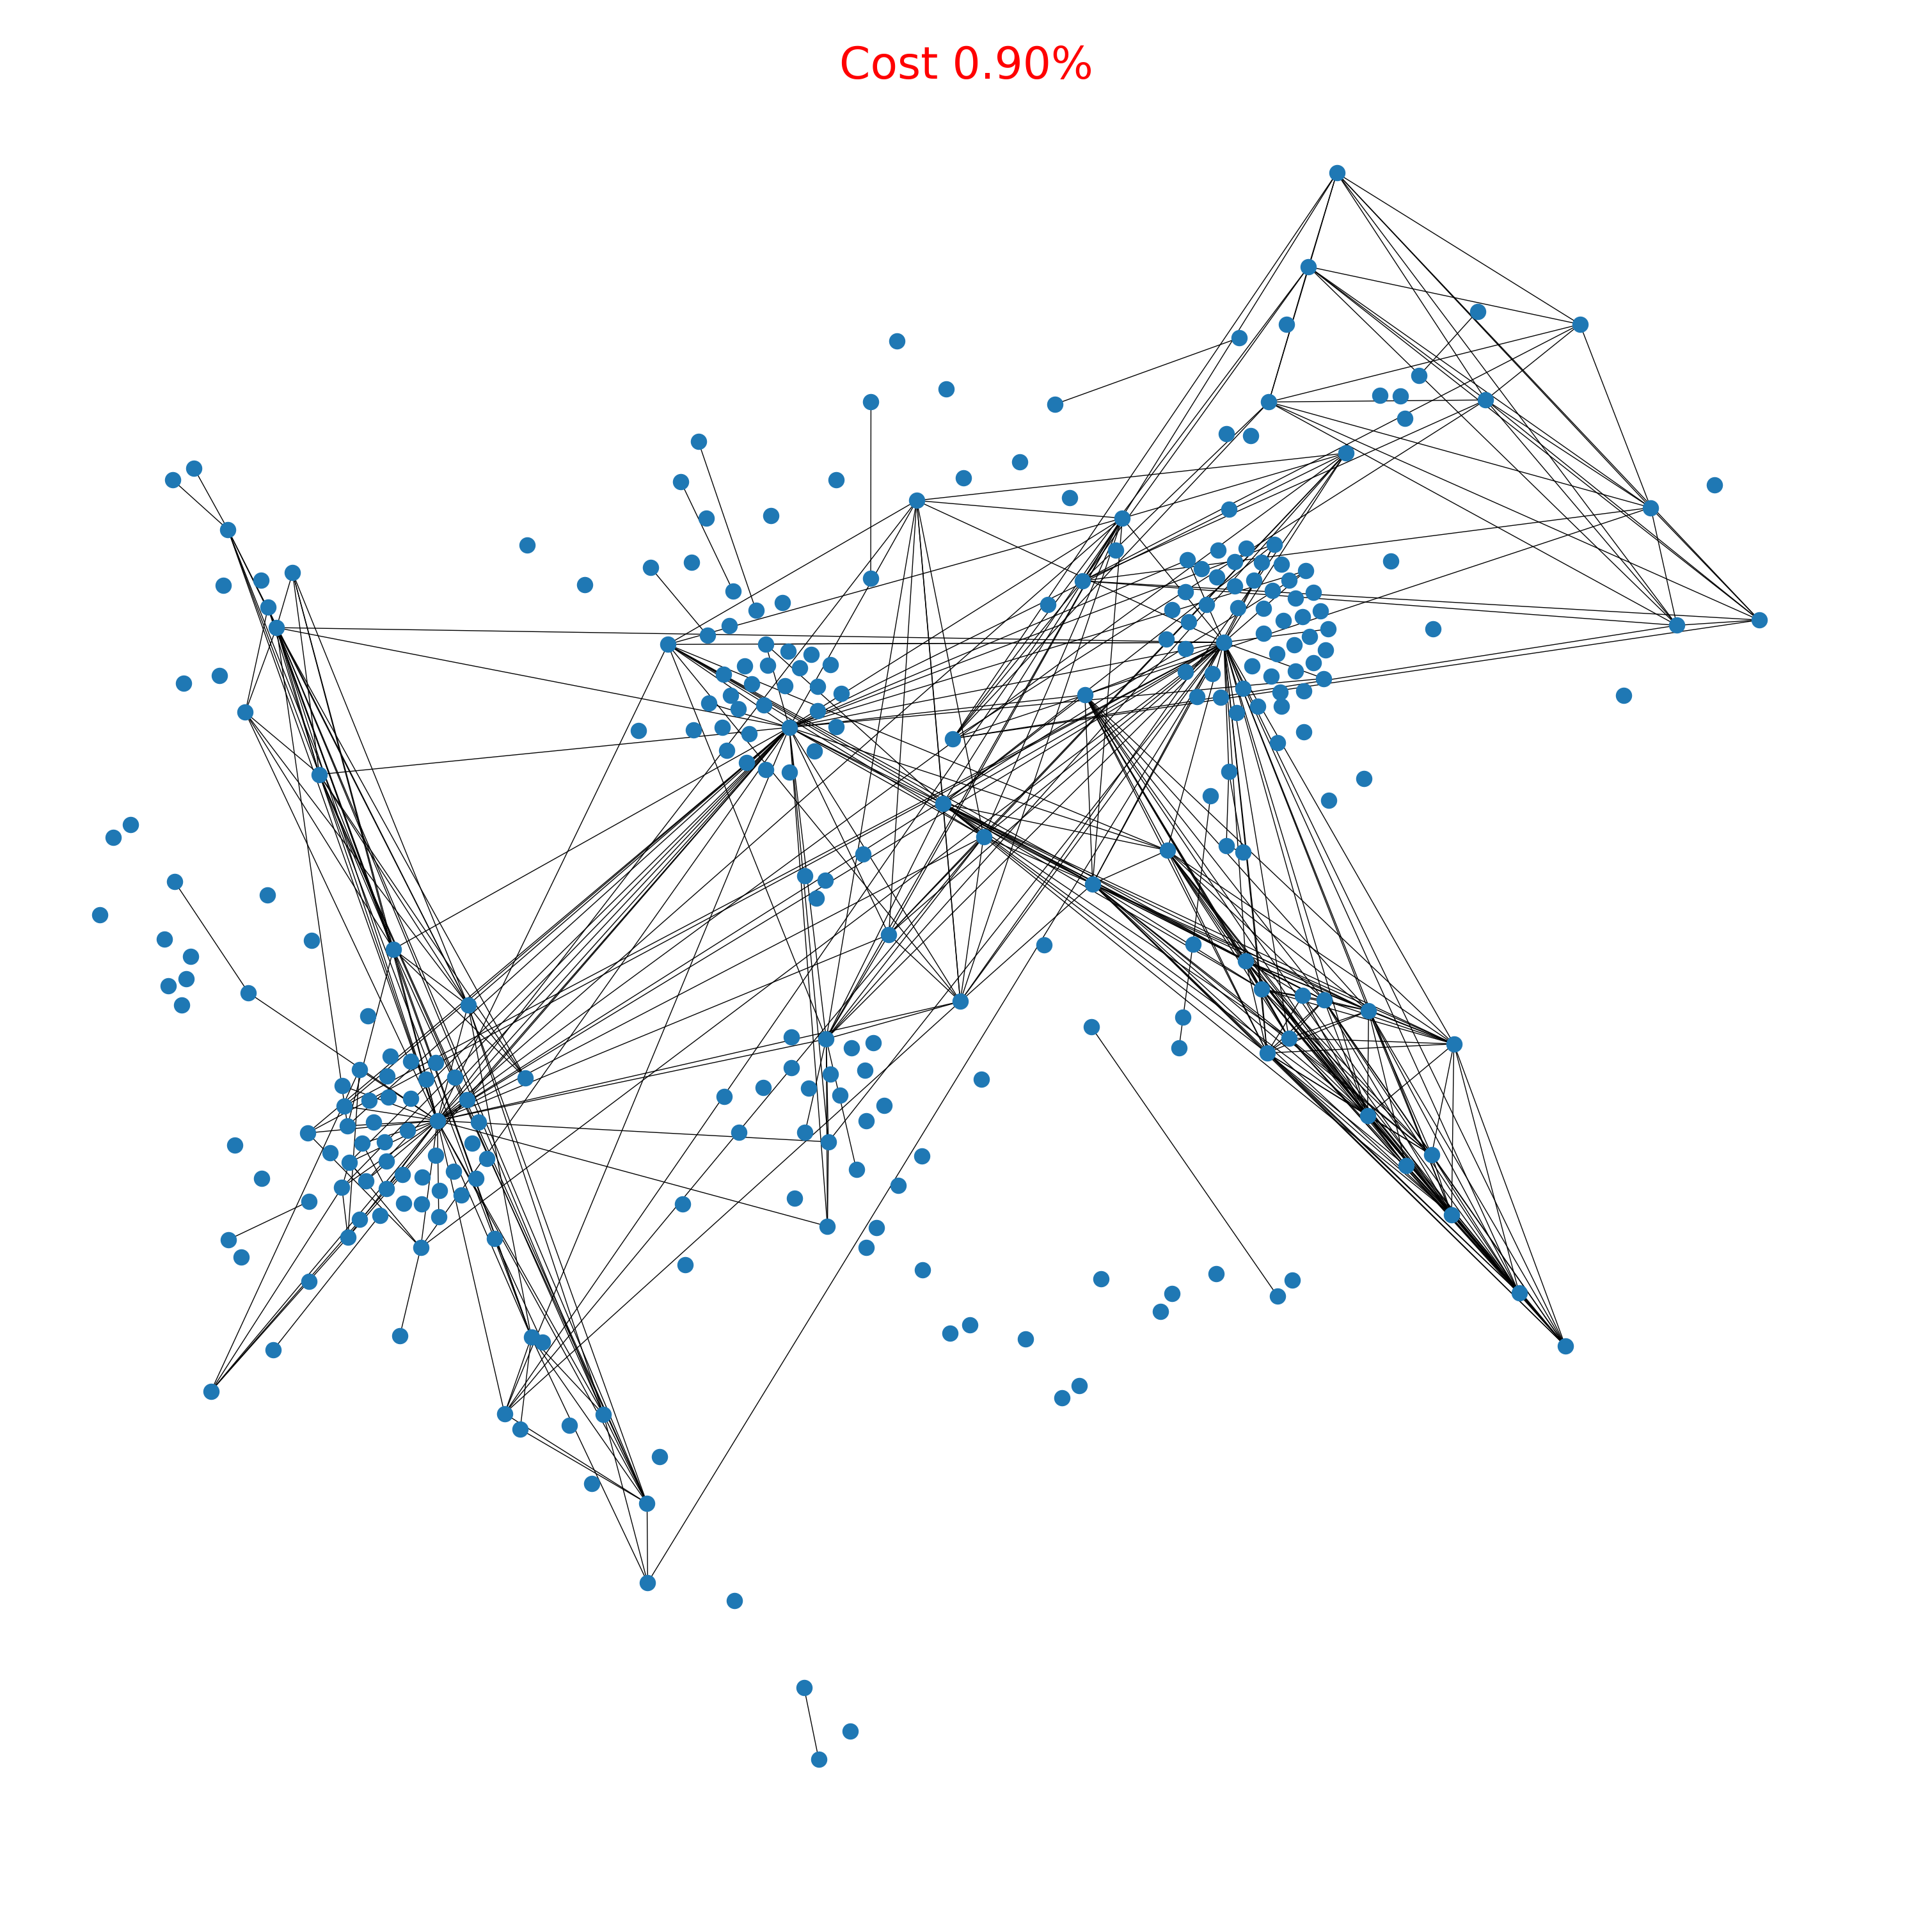

In [ ]:
G = nx.from_numpy_array(np.asmatrix(distances))
G = nx.relabel_nodes(G,lambda x: distances.index[x])
T = nx.minimum_spanning_tree(G)
pos = nx.fruchterman_reingold_layout(T)

for cost in [0.001, 0.002, 0.0037, 0.009]:
    cutoff = values[int(cost*300*299)]

    for i in range(0, 300):
        for j in range(i + 1, 300):

            weight = distances.iat[i, j]
            if weight < cutoff:
                T.add_edge(i, j, weight = weight)
            elif T.has_edge(i, j):
                T.remove_edge(i, j)

    plt.figure(figsize=(30, 30))
    plt.suptitle('Cost {:.2f}%'.format(cost*100), fontsize = 50, color = 'r')
    nx.draw(T, pos, with_labels=False,
    edge_color = "black",
    width = 1,
    font_size=25)

# Graph Growth (Black-Scholes Model):

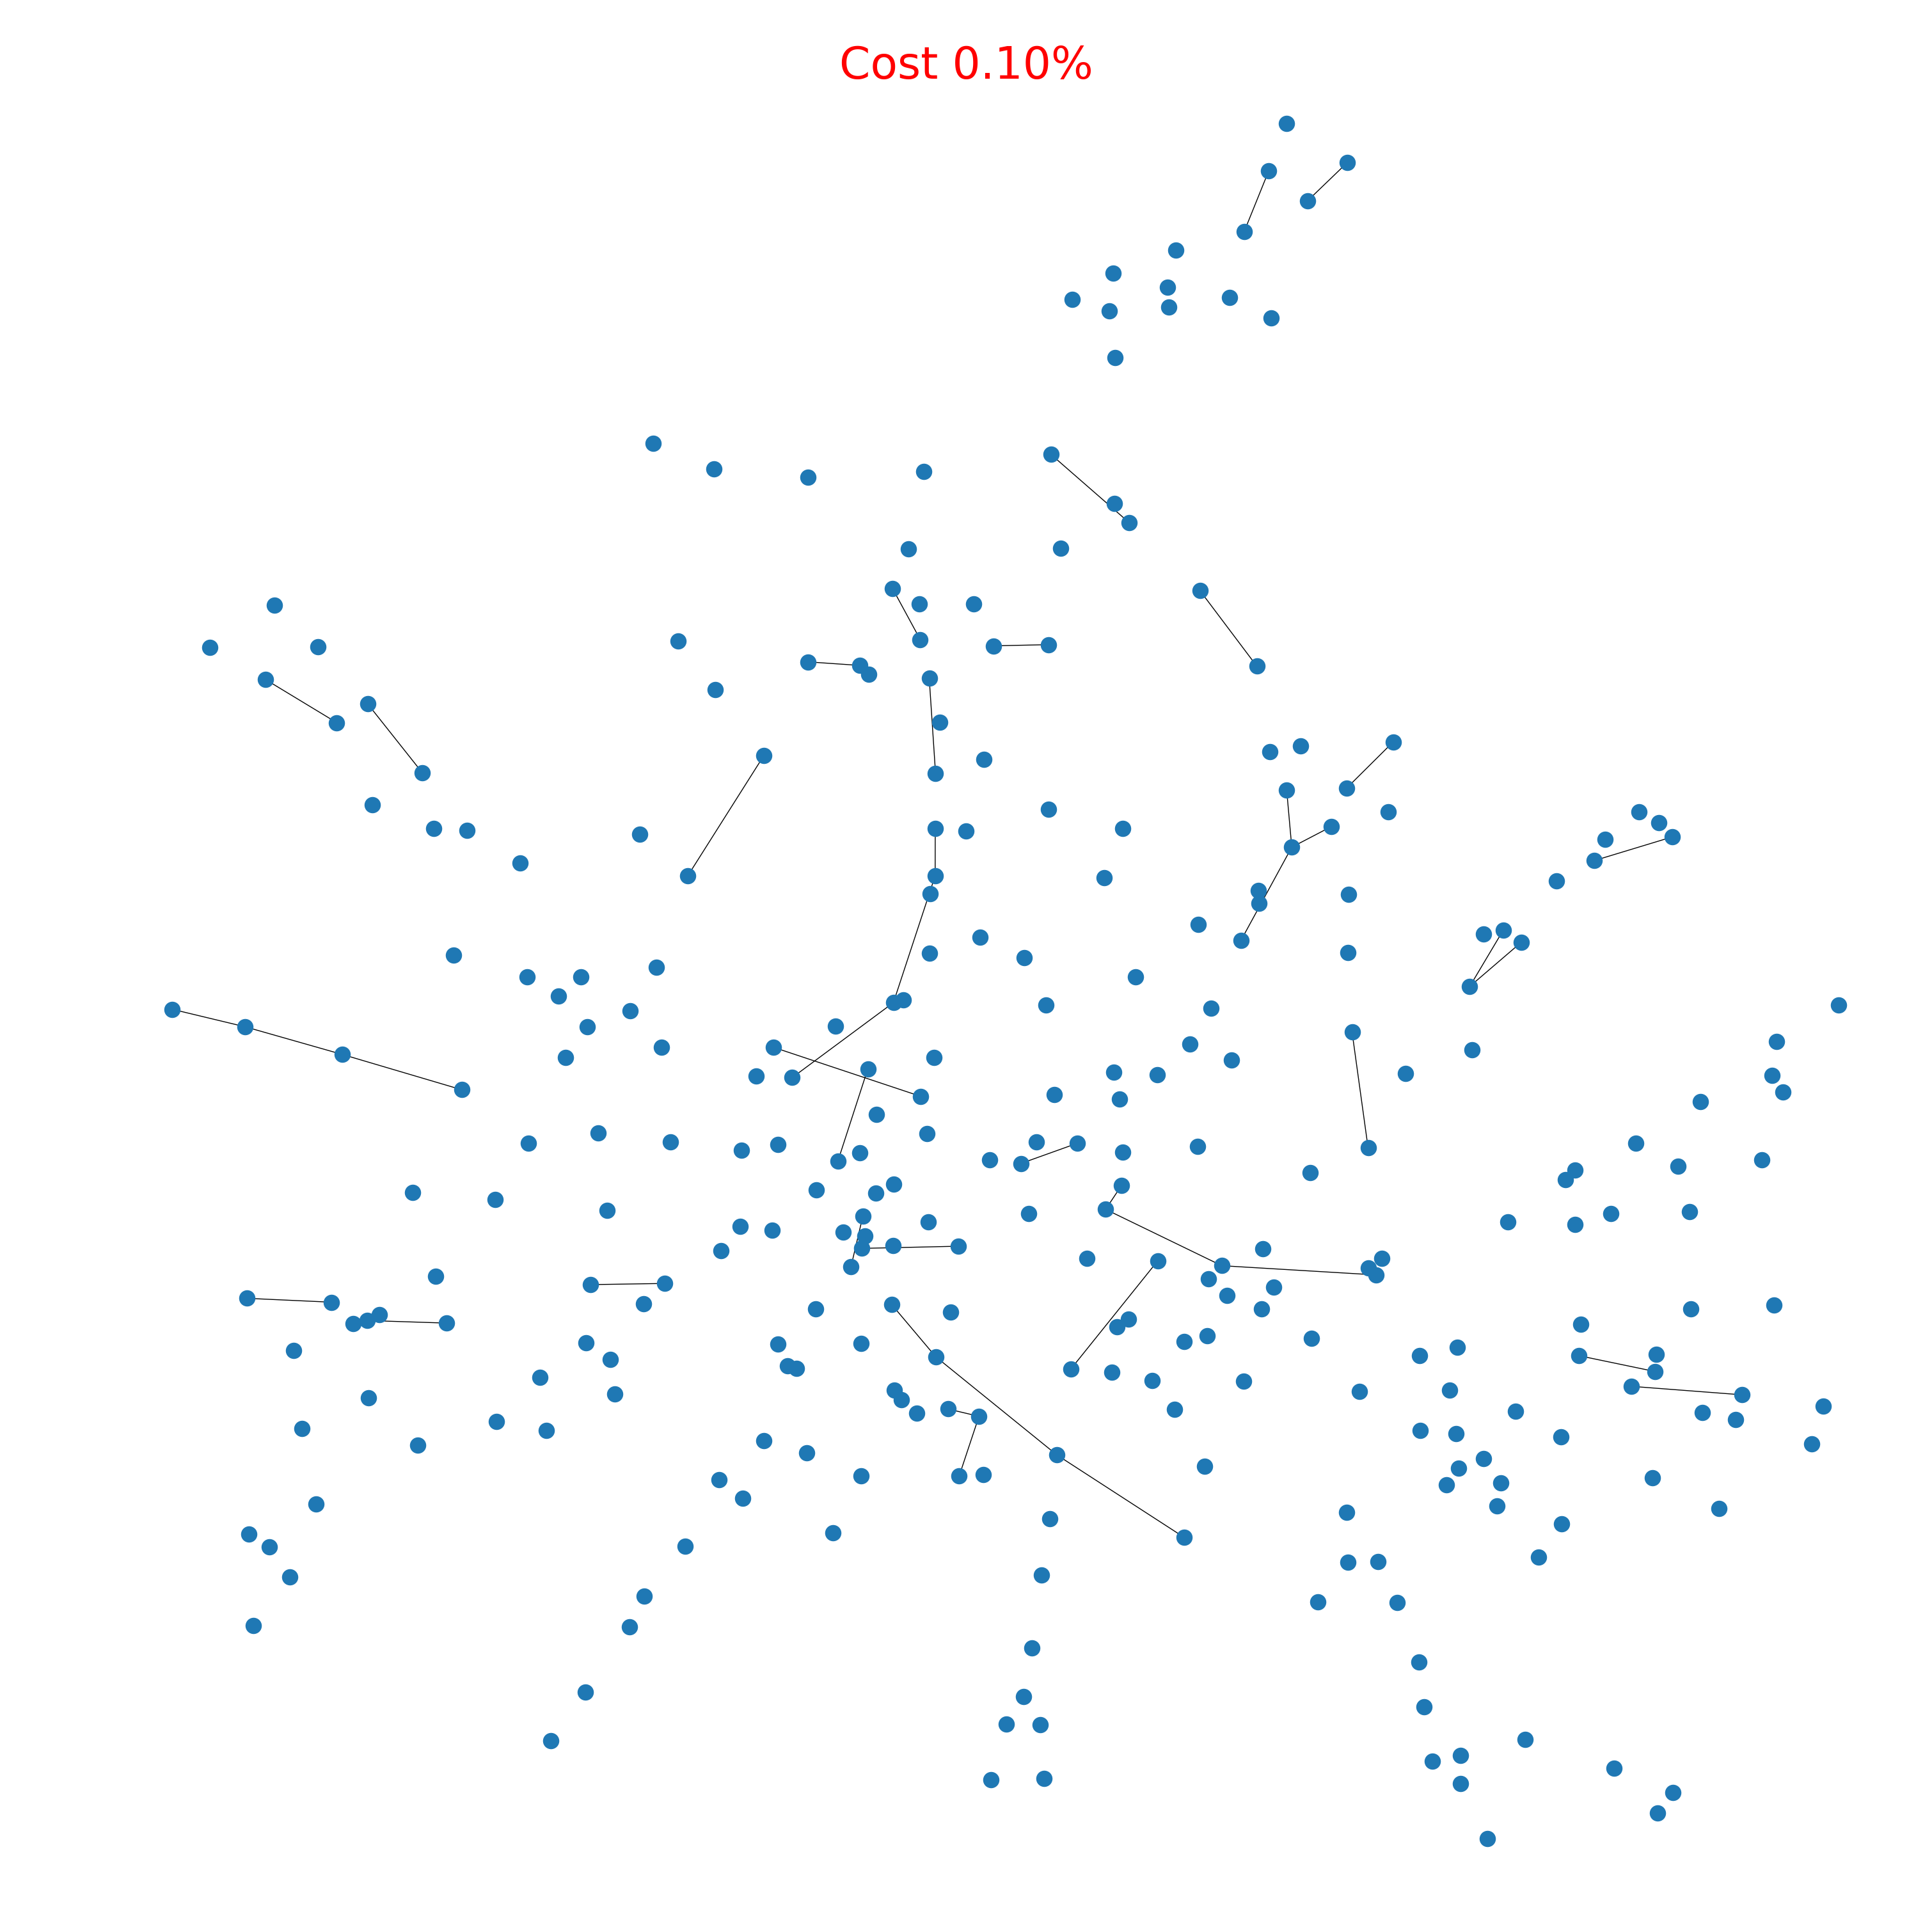

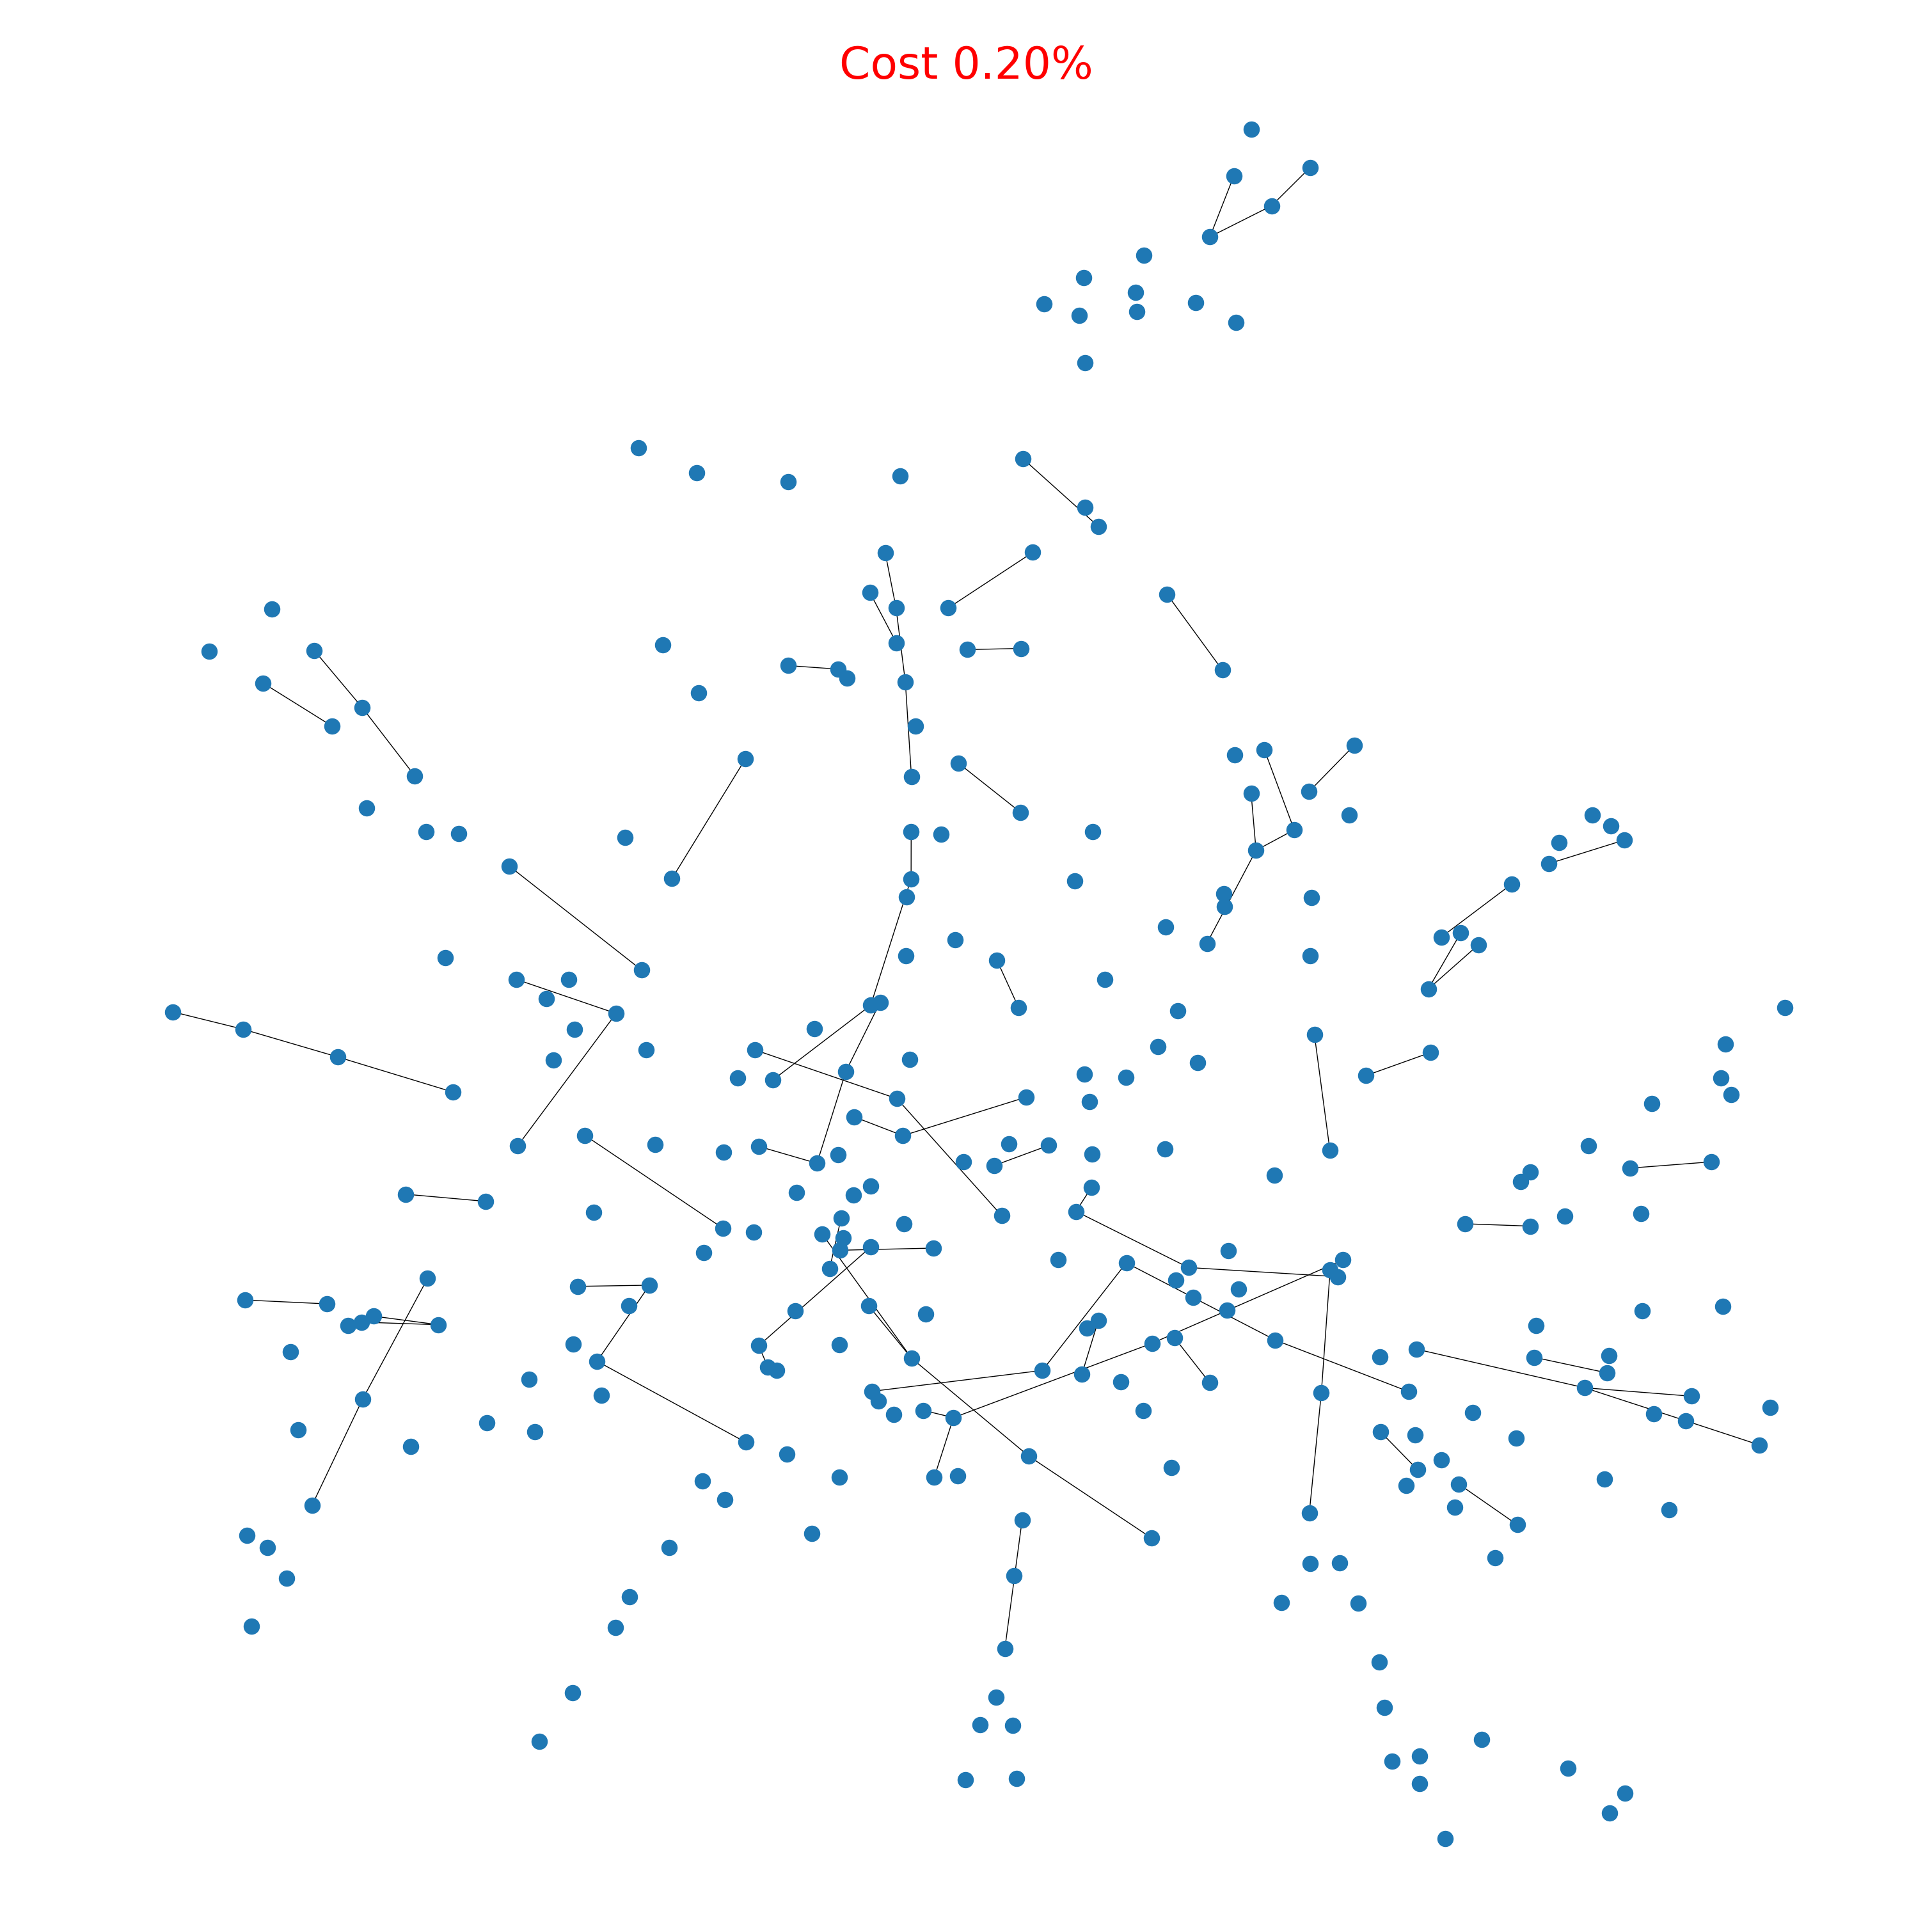

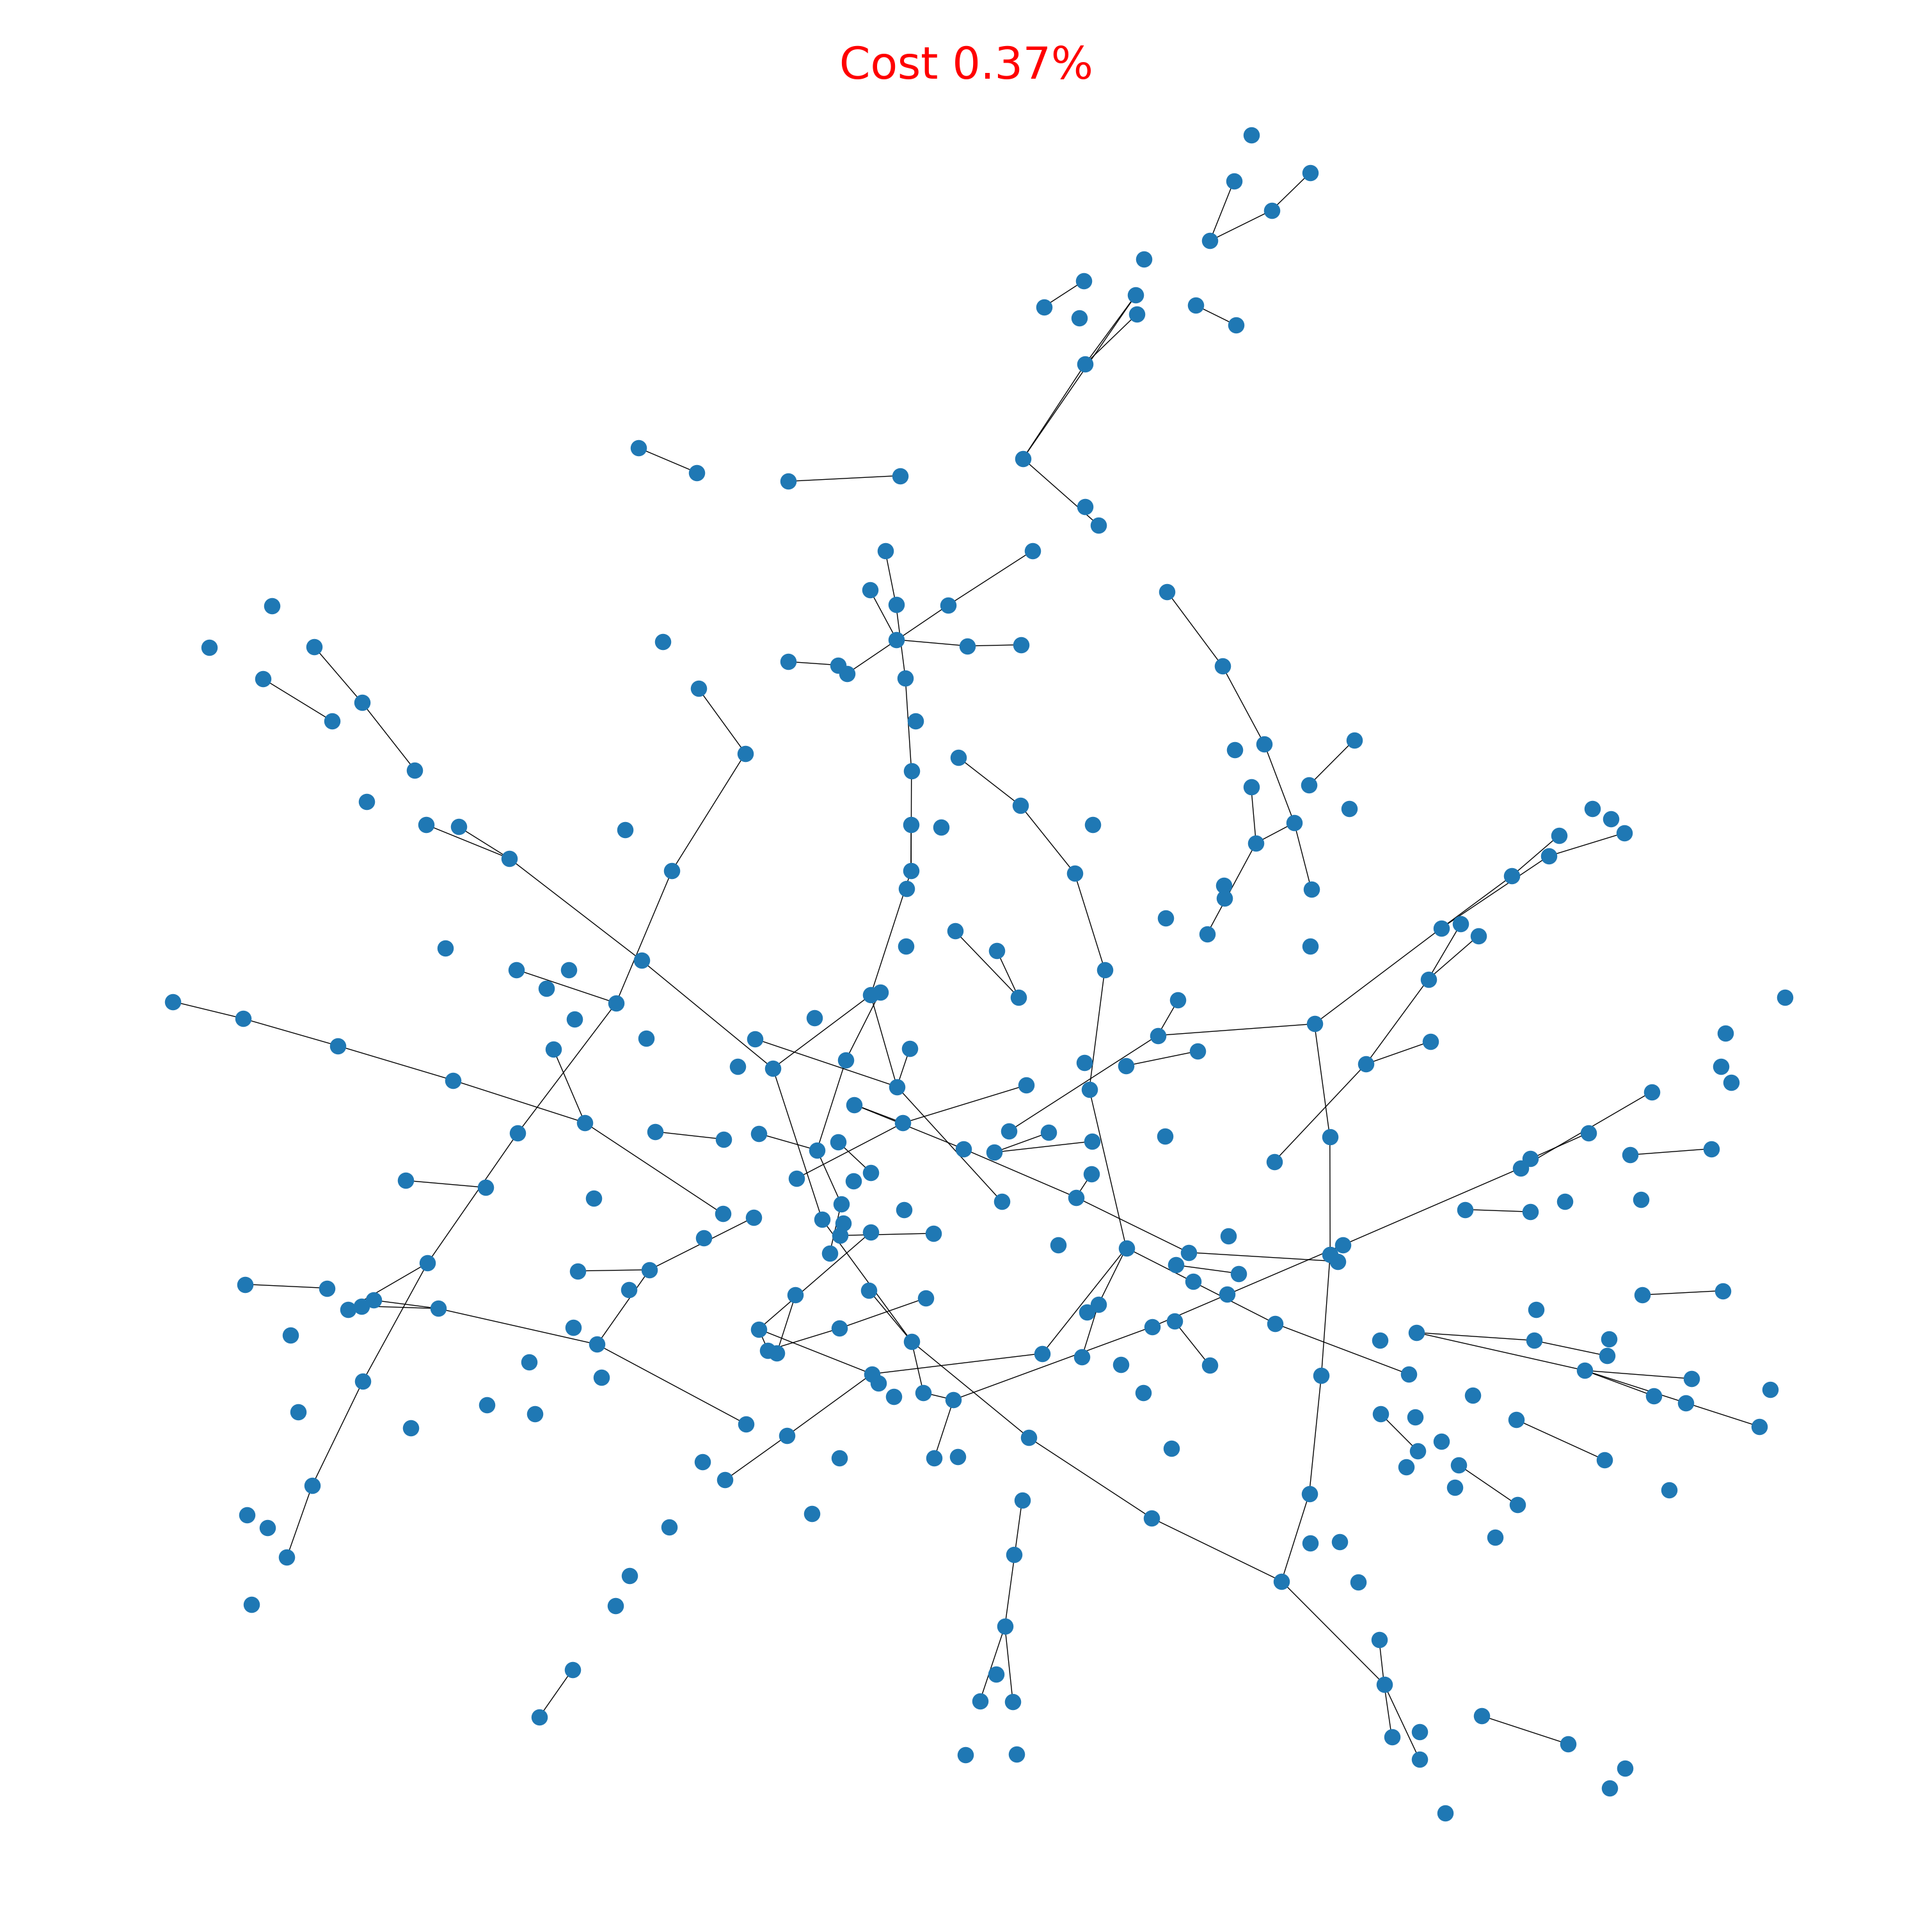

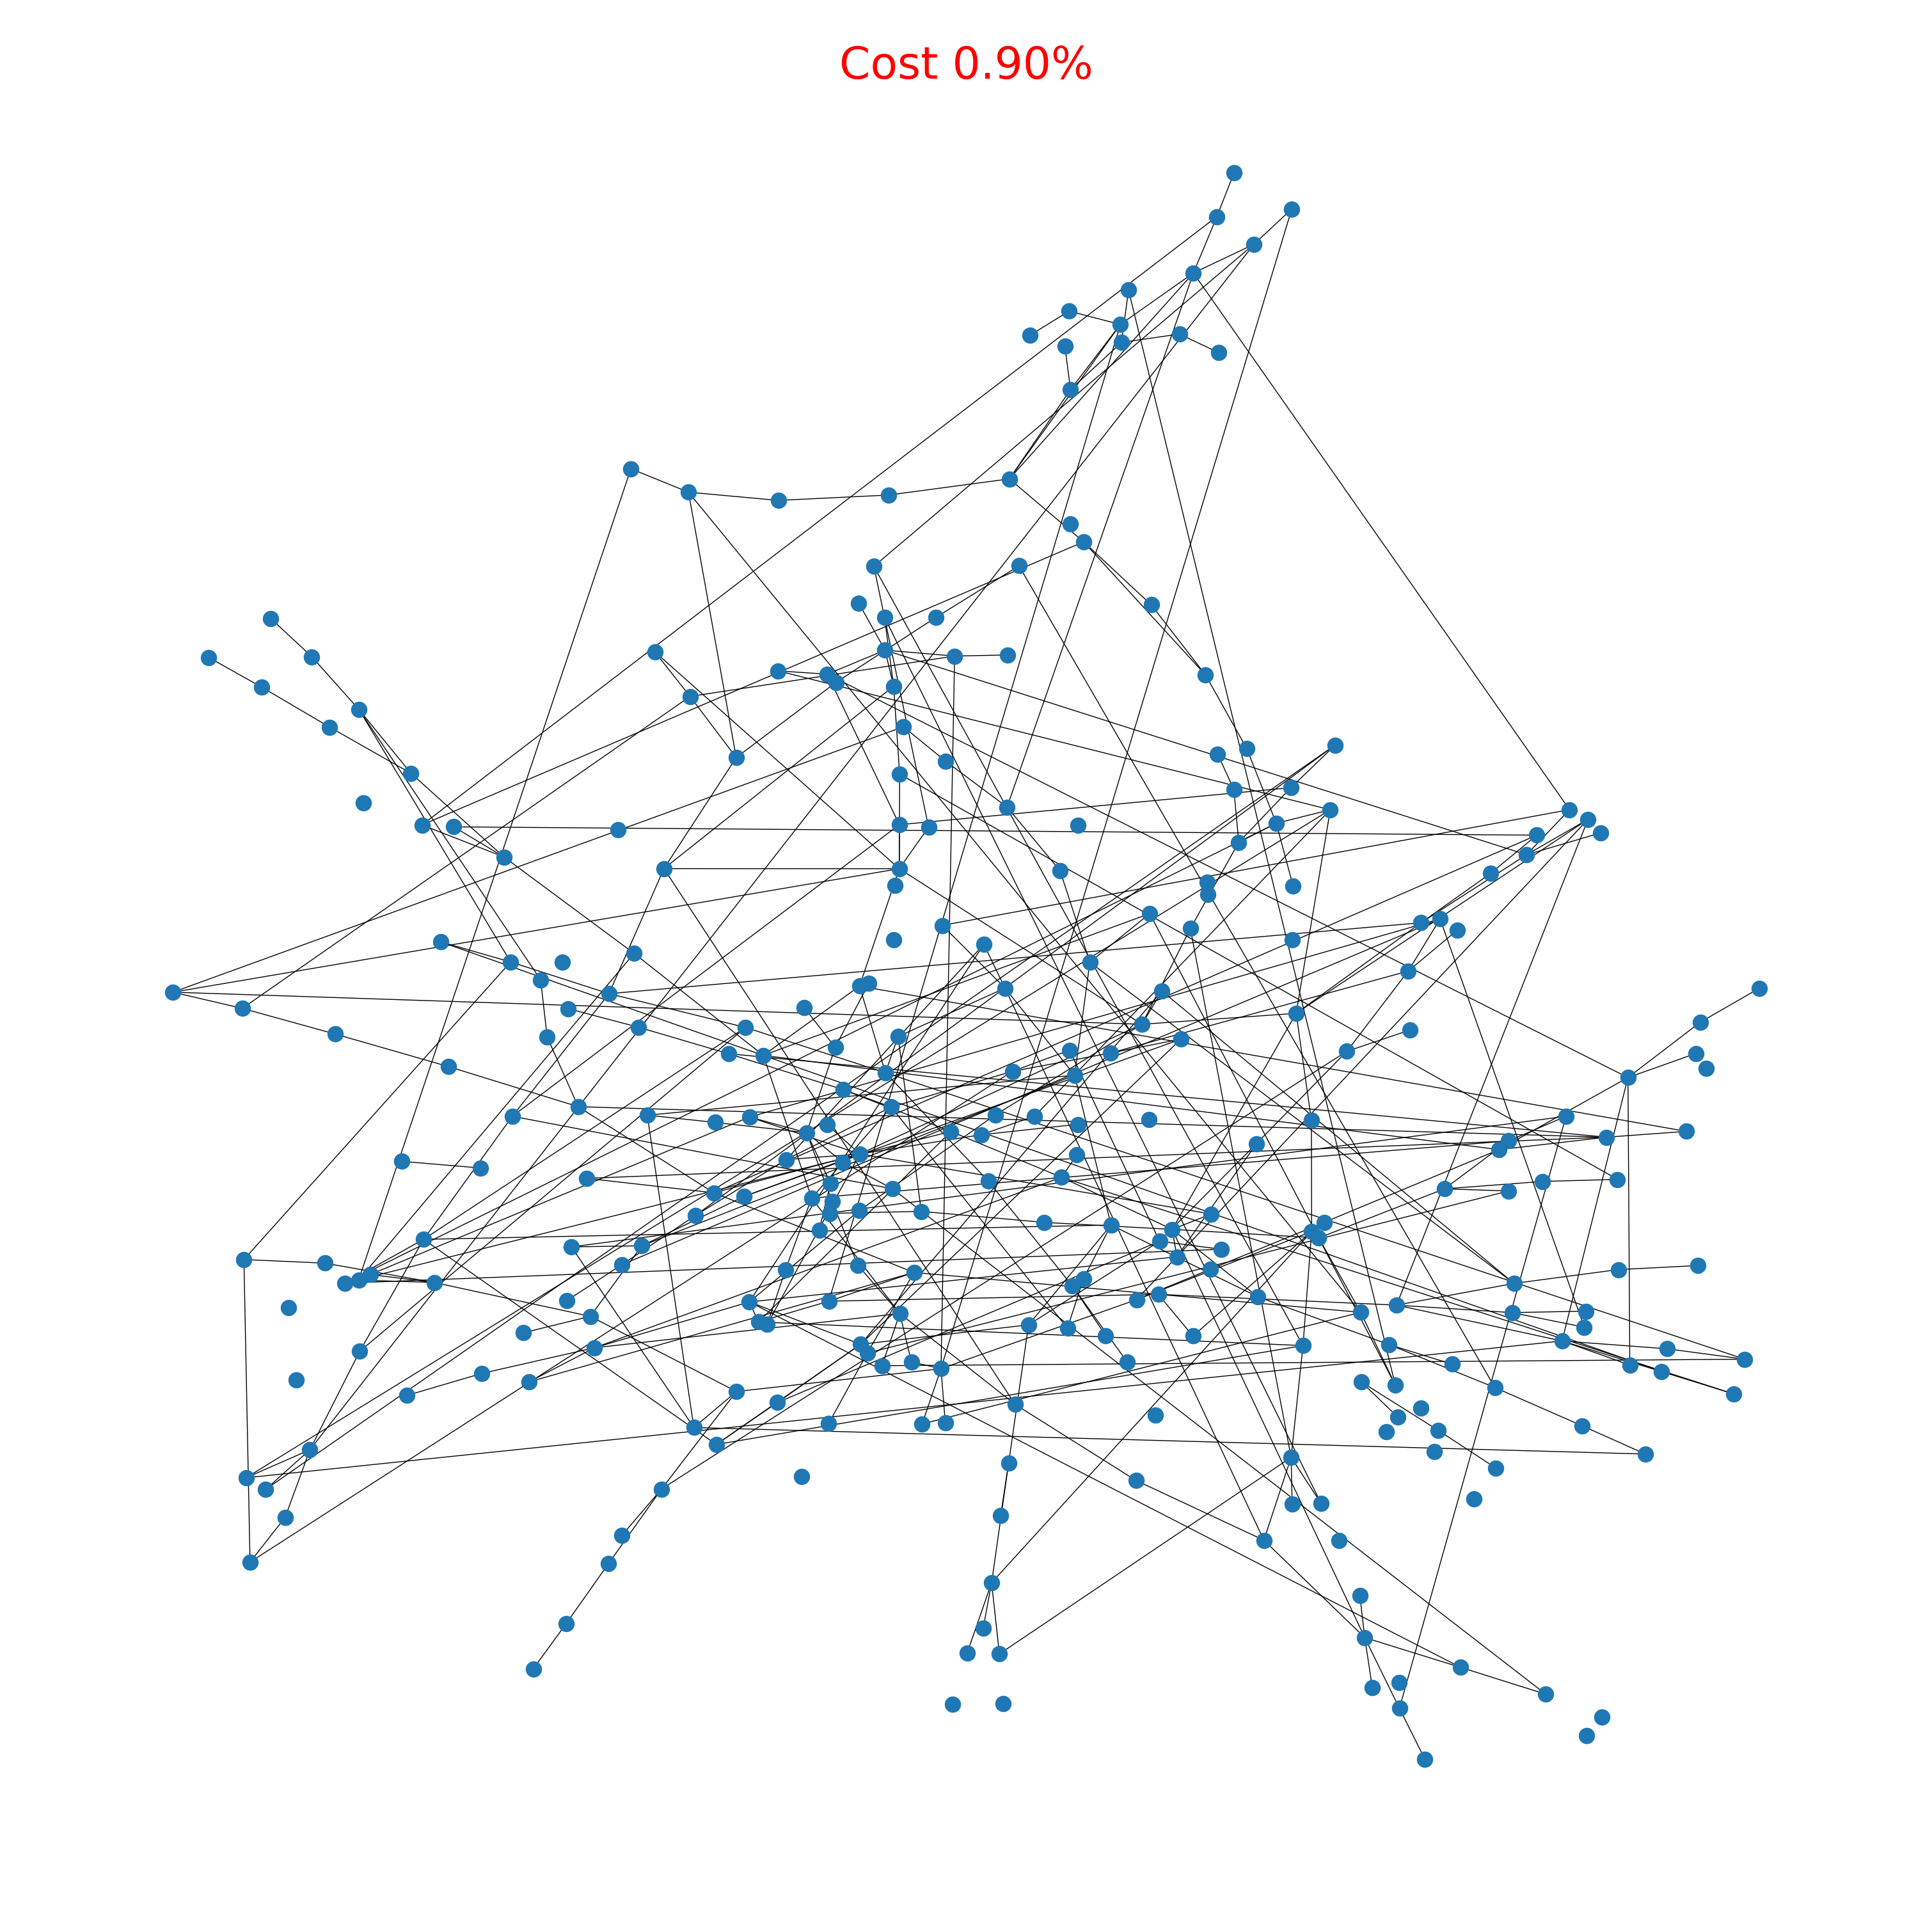

In [ ]:
G = nx.from_numpy_array(np.asmatrix(bsdistances))
G = nx.relabel_nodes(G,lambda x: bsdistances.index[x])
T = nx.minimum_spanning_tree(G)
pos = nx.fruchterman_reingold_layout(T)

for cost in [0.001, 0.002, 0.0037, 0.009]:
    cutoff = bsvalues[int(cost*300*299)]

    for i in range(0, 300):
        for j in range(i + 1, 300):

            weight = bsdistances.iat[i, j]
            if weight < cutoff:
                T.add_edge(i, j, weight = weight)
            elif T.has_edge(i, j):
                T.remove_edge(i, j)

    plt.figure(figsize=(30, 30))
    plt.suptitle('Cost {:.2f}%'.format(cost*100), fontsize = 50, color = 'r')
    nx.draw(T, pos, with_labels=False,
    edge_color = "black",
    width = 1,
    font_size=25)

# Comparison of topological measures as a function of connection density:

In [ ]:
G = nx.from_numpy_array(np.asmatrix(distances))
G = nx.relabel_nodes(G,lambda x: distances.index[x])
T = nx.minimum_spanning_tree(G)
assortavity = []
clustering = []
global_efficiency = []
modularity = []

for cost in np.arange(0, 1, 0.025):
    for i in range(0, 300):
        for j in range(i + 1, 300):
            cutoff = values[int(cost*300*299)]
            weight = distances.iat[i, j]
            if weight < cutoff:
                T.add_edge(i, j, weight = weight)

    assortavity.append(nx.degree_assortativity_coefficient(T))
    clustering.append(nx.average_clustering(T))
    global_efficiency.append(nx.global_efficiency(T))
    communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(T)
    modularity.append(nx.algorithms.community.modularity(T, communities))

In [ ]:
G = nx.from_numpy_array(np.asmatrix(bsdistances))
G = nx.relabel_nodes(G,lambda x: bsdistances.index[x])
T = nx.minimum_spanning_tree(G)
assortavity1 = []
clustering1 = []
global_efficiency1 = []
modularity1 = []

for cost in np.arange(0, 1, 0.025):
    for i in range(0, 300):
        for j in range(i + 1, 300):
            cutoff = bsvalues[int(cost*300*299)]
            weight = bsdistances.iat[i, j]
            if weight < cutoff:
                T.add_edge(i, j, weight = weight)

    assortavity1.append(nx.degree_assortativity_coefficient(T))
    clustering1.append(nx.average_clustering(T))
    global_efficiency1.append(nx.global_efficiency(T))
    communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(T)
    modularity1.append(nx.algorithms.community.modularity(T, communities))

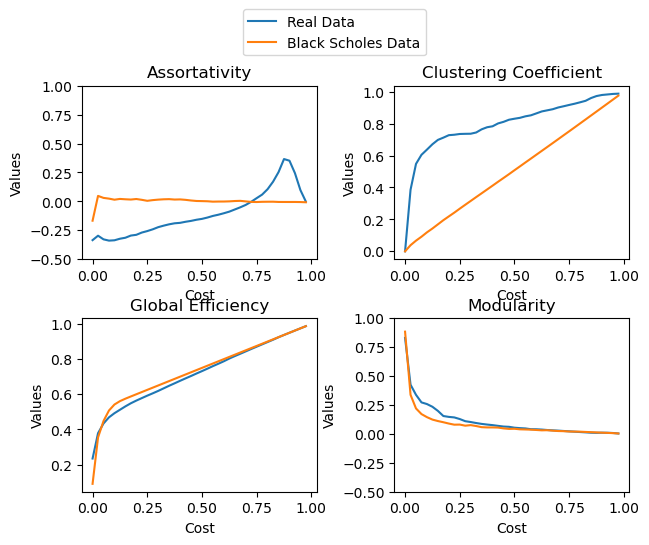

In [ ]:
fig, axs = plt.subplots(2, 2)
l1 = axs[0, 0].plot(np.arange(0, 1, 0.025), assortavity, label = 'Real Data')
l2 = axs[0, 0].plot(np.arange(0, 1, 0.025), assortavity1, 'tab:orange', label = 'Black Scholes Data')
axs[0, 0].set_ylim([-0.5, 1])
axs[0, 0].set_title('Assortativity')
axs[0, 1].plot(np.arange(0, 1, 0.025), clustering)
axs[0, 1].plot(np.arange(0, 1, 0.025), clustering1, 'tab:orange')
axs[0, 1].set_title('Clustering Coefficient')
axs[1, 0].plot(np.arange(0, 1, 0.025), global_efficiency)
axs[1, 0].plot(np.arange(0, 1, 0.025), global_efficiency1, 'tab:orange')
axs[1, 0].set_title('Global Efficiency')
axs[1, 1].plot(np.arange(0, 1, 0.025), modularity)
axs[1, 1].plot(np.arange(0, 1, 0.025), modularity1, 'tab:orange')
axs[1, 1].set_ylim([-0.5, 1])
axs[1, 1].set_title('Modularity')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
for ax in axs.flat:
    ax.set(xlabel='Cost', ylabel='Values')